In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
import ast

from lib.functions_data import *

In [2]:
import sys
from pathlib import Path
import os
cwd = os.getcwd()
parent = str(Path(cwd).parents[0])
sys.path.append(parent)

%matplotlib inline
%load_ext autoreload
%autoreload 2

The functions_data.py file contains:
1. A dictionary mapping EU/EEA country abbreviations to country names
2. The first date in which an EUCTR protocol was entered for each EU/EEA country (see how these were gathered below)
3. A mapping of NCA names from the EUCTR to a more updated list of names
4. The following functions:  
a. earliest_record_check: Derive the earliest protocol date data for any country from an EU TrialsTracker scrape  
b. zeo_out_dict: Adds zeros to years with no data for relevant analyses.  
c. compare_enrollment_registration: A function that does the heavy lifting for comparing data from EUCTR results to regustered protocols

In [897]:
#Only the columns we need for the analysis to save memory
cols = ['eudract_number_with_country', 'date_of_competent_authority_decision',
       'clinical_trial_type', 'national_competent_authority', 'eudract_number',
       'date_on_which_this_record_was_first_entered_in_the_eudract_data',
       'trial_status', 'date_of_the_global_end_of_the_trial', 'trial_results']

#You can copy this URL if you want to download the full data
data_link = 'https://www.dropbox.com/s/4qt0msiipyn7crm/euctr_euctr_dump-2020-12-03-095517.csv.zip?dl=1'

dec = pd.read_csv(data_link, compression='zip', low_memory=False, usecols=cols)

results_info = pd.read_csv(parent + '/data/euctr_data_quality_results_scrape_dec_2020.csv')
results_info['trial_start_date'] = pd.to_datetime(results_info.trial_start_date)

In [5]:
#Quick look at the spread of trial statuses on the EUCTR
dec.trial_status.value_counts(dropna=False)

Completed             52035
Ongoing               31573
Prematurely Ended     11399
NaN                    2586
Temporarily Halted      498
Restarted               398
Not Authorised           73
Prohibited by CA         38
Suspended by CA          22
Name: trial_status, dtype: int64

The "date_of_competent_authority_decision" field has 2 nonsensical year values in which the correct value can reasonably be derived from context. We fix those below:

https://www.clinicaltrialsregister.eu/ctr-search/trial/2009-016759-22/DK

https://www.clinicaltrialsregister.eu/ctr-search/trial/2006-006947-30/FR

In [6]:
ind = dec[dec.date_of_competent_authority_decision.notnull() & 
          dec.date_of_competent_authority_decision.str.contains('210')].index
ind = ind.to_list()[0]

ind_2 = dec[dec.date_of_competent_authority_decision.notnull() & 
            dec.date_of_competent_authority_decision.str.contains('2077')].index
ind_2 = ind_2.to_list()[0]

dec.at[ind, 'date_of_competent_authority_decision'] = '2010-06-18'
dec.at[ind_2, 'date_of_competent_authority_decision'] = '2007-04-05'

In [7]:
#get rid of all protocols from non EU/EEA countries
dec_filt = dec[dec.clinical_trial_type != 'Outside EU/EEA'].reset_index(drop=True)

#lets see how many that is:
print(len(dec) - len(dec_filt))

1395


In [8]:
#Making dates into dates and adding a column of just the "Year" for relevant dates

dec_filt['date_on_which_this_record_was_first_entered_in_the_eudract_data'] = pd.to_datetime(dec_filt['date_on_which_this_record_was_first_entered_in_the_eudract_data'])
dec_filt['entered_year'] = dec_filt['date_on_which_this_record_was_first_entered_in_the_eudract_data'].dt.year

dec_filt['date_of_competent_authority_decision'] = pd.to_datetime(dec_filt['date_of_competent_authority_decision'])
dec_filt['approved_year'] = dec_filt['date_of_competent_authority_decision'].dt.year

In [9]:
#You can reproduce the data on the earliest registered protocol for each country by running this cell
#with the appropriate country abbreviation. For example, 'IT' for Italy:

print(earliest_record_check(dec_filt, 'IT'))

#Uncomment this to get the date for all countries at once
#for abrev in country_abrevs.keys():
#    print(f'Country: {abrev}\nEarliest record date: {earliest_record_check(dec_filt, abrev)}')

2004-07-16


In [10]:
#Creating a copy of the original dataset we can mess with and
#renaming columns to better variable names

analysis_df = dec_filt.copy()
analysis_df.columns = ['eudract_number_country', 
                       'approved_date', 
                       'clinical_trial_type', 
                       'nca', 
                       'eudract_number', 
                       'date_entered', 
                       'trial_status', 
                       'completion_date', 
                       'trial_results', 
                       'entered_year', 
                       'approved_year']

#And update the NCA names to the more accurate recent names

analysis_df['nca'] = analysis_df['nca'].replace(nca_name_mapping)

In [11]:
ordered_countries_original = list(dec_filt.national_competent_authority.value_counts().index)
ordered_countries_new = list(analysis_df.nca.value_counts().index)

# Registrations Over Time

In [760]:
reg_df = analysis_df[['eudract_number', 'nca', 'date_entered', 'entered_year', 'approved_date', 'approved_year']].reset_index(drop=True)

In [13]:
reg_df.head()

eudract_number                    nca date_entered  entered_year
0  2019-000796-16  Czech Republic - SUKL   2020-03-17          2020
1  2008-000679-90        Belgium - FAMHP   2008-06-18          2008
2  2010-022818-19         Ireland - HPRA   2011-02-15          2011
3  2008-000679-90        Germany - BfArM   2008-05-20          2008
4  2016-000541-31        Belgium - FAMHP   2016-10-18          2016

In [639]:
#Data for Overall Trend in Registrations

grouped_overall = reg_df[['eudract_number']].groupby([reg_df.entered_year]).count()

In [640]:
grouped_overall.head()

eudract_number
entered_year                
2004                    1068
2005                    4636
2006                    5809
2007                    7048
2008                    7080

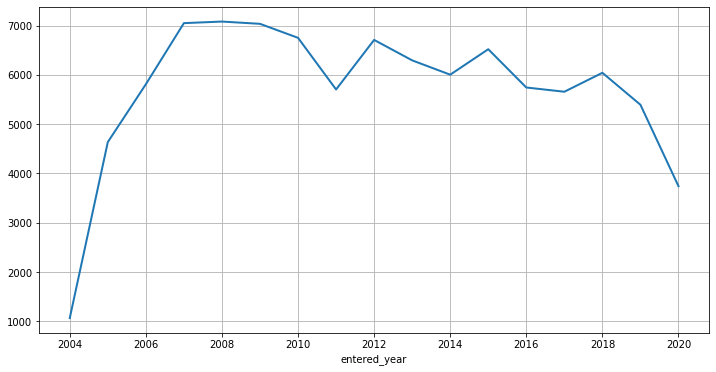

In [641]:
fig, ax = plt.subplots(figsize = (12,6))

grouped_overall.plot(ax=ax, legend=False, grid=True, lw=2)

fig.show()

We can drop 2004 (data from, at most, July onwards) and 2020 (data only through 1 Dec) as years with incomplete data in this dataset in order to get more accurate trend data. We can also then graph the totaly number of proto against the total number of new unique trials by the earliest trial entry date.

In [642]:
earliest_entered = reg_df[['eudract_number', 'date_entered']].groupby('eudract_number', as_index=False).min()
earliest_entered['year'] = earliest_entered.date_entered.dt.year
unique_trials = earliest_entered[['eudract_number', 'year']].groupby('year').count()

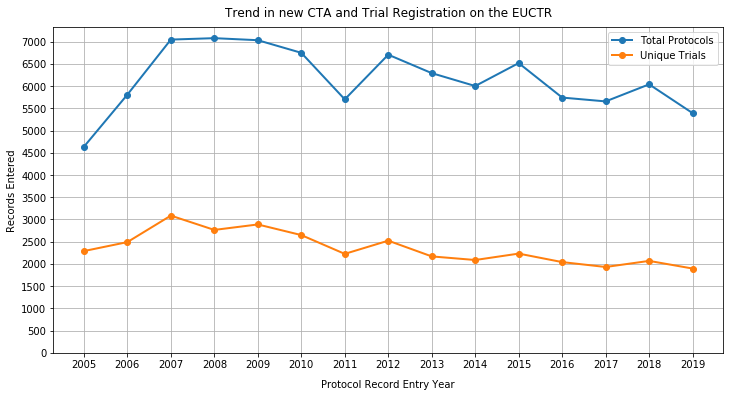

In [828]:
fig, ax = plt.subplots(figsize = (12,6))

grouped_overall[(grouped_overall.index > 2004) & (grouped_overall.index < 2020)].plot(ax=ax, legend=False, lw=2, 
                                                                                      marker='.', markersize=12)
unique_trials[(unique_trials.index > 2004) & (unique_trials.index < 2020)].plot(ax=ax, legend=False, grid=True, 
                                                                                lw=2, marker='.', markersize=12)

ax.legend(['Total Protocols', 'Unique Trials'], bbox_to_anchor = (1, 1))
ax.set_xticks(range(2005, 2020))
ax.set_yticks(range(0,7500, 500))
plt.xlabel('Protocol Record Entry Year', labelpad=10)
plt.ylabel('Records Entered')
plt.title('Trend in new CTA and Trial Registration on the EUCTR', pad=10)

fig.show()

Now we're interested in breaking the data down a bit further. Here we will break it down into quarters and overall to get the full list of quarters in our time series.

In [19]:
grouped = reg_df[['eudract_number']].groupby([reg_df.nca, pd.PeriodIndex(reg_df.date_entered, freq='Q')]).count()

get_index = reg_df[['eudract_number']].groupby(pd.PeriodIndex(reg_df.date_entered, freq='Q')).count()
quarters = list(get_index.index)

In [315]:
country = grouped.loc[ordered_countries_new[5]]
first_reporting_quarter = country[country.eudract_number > 0].index.min()
adjusted_data = zero_out_dict(country.to_dict()['eudract_number'], quarters)
data = pd.DataFrame({'eudract_number': adjusted_data})

In [363]:
c_dict = {}

for c in ordered_countries_new:    
    country = grouped.loc[c]
    first_reporting_quarter = country[country.eudract_number > 0].index.min()
    adjusted_data = zero_out_dict(country.to_dict()['eudract_number'], quarters) 
    data = pd.DataFrame({'eudract_number': adjusted_data})
    data['const'] = 1

    #Get rid of leading zeros
    data['eudract_number'] = np.where(data.index < first_reporting_quarter, np.nan, data.eudract_number)
    
    consolidated = data[(data.index.year > 2004) & (data.index.year < 2020)].reset_index(drop=True)
    
    leading_zero_check = True
    i=0
    
    while leading_zero_check:
        if consolidated.eudract_number[i] == 0:
            consolidated.at[consolidated.index[i], 'eudract_number'] = np.nan
            i+=1
        else:
            leading_zero_check = False
    
    l = consolidated.eudract_number.to_list()
    c_dict[c] = l

In [368]:
import pyreadr

df = pd.DataFrame(c_dict)
pyreadr.write_rds(parent + "/data/df.Rds", df)

See the R script in the Repo to reproduce the p-values from the linear trend tests (`notrend_test`) from the `funtimes` package.

Details: https://www.rdocumentation.org/packages/funtimes/versions/6.1/topics/notrend.test

In [374]:
p_vals = pyreadr.read_r(parent + '/data/df_R.Rds')

In [392]:
pv_df = p_vals[None].T
new_index = ordered_countries_new.copy()
new_index.remove('Croatia - MIZ')
pv_df['new_countries'] = new_index
pv_df = pv_df.set_index('new_countries')

In [ ]:
#Consider switching to this

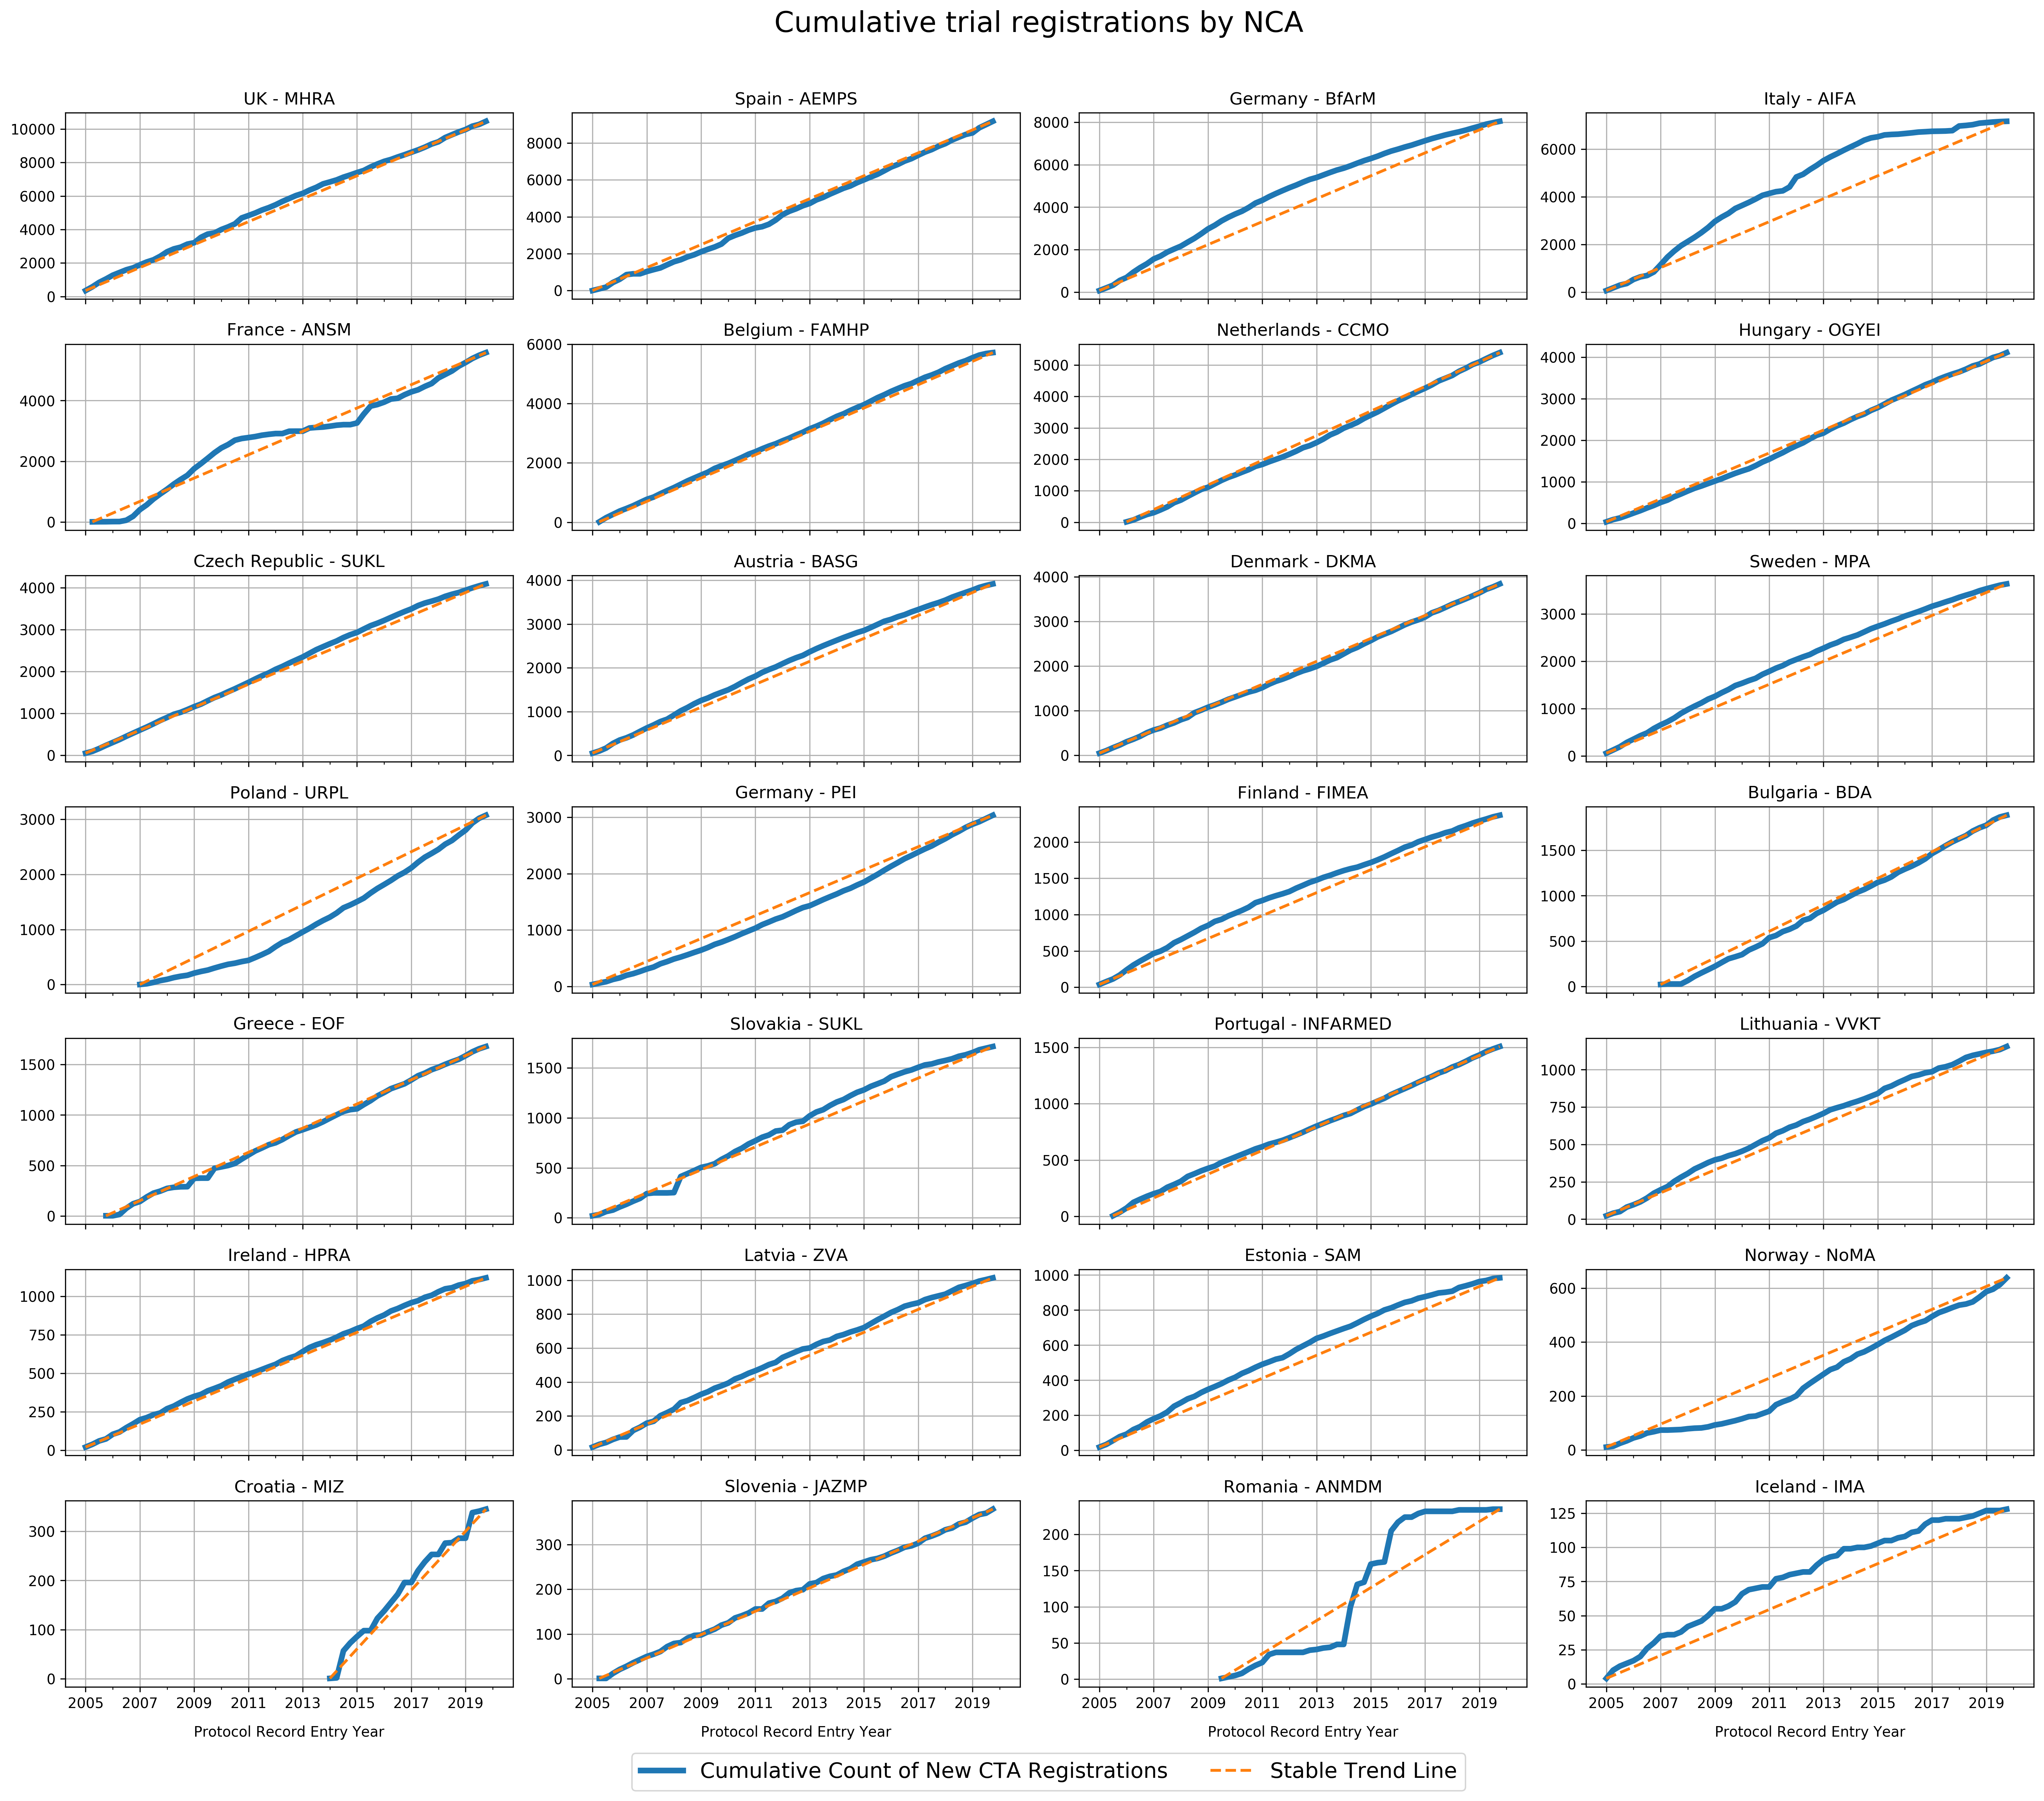

In [756]:
fig, axes = plt.subplots(figsize = (20, 16), nrows=7, ncols=4, dpi=300)
fig.suptitle("Cumulative trial registrations by NCA", y=1.05, fontsize=20)
fig.tight_layout()

pd.set_option('mode.chained_assignment', None)
for x, y in enumerate(fig.axes):
    country = grouped.loc[ordered_countries_new[x]]
    first_reporting_quarter = country[country.eudract_number > 0].index.min()
    adjusted_data = zero_out_dict(country.to_dict()['eudract_number'], quarters) 
    data = pd.DataFrame({'eudract_number': adjusted_data})
    x_ticks = data.index
    
    #Get rid of leading zeros
    data['eudract_number'] = np.where(data.index < first_reporting_quarter, np.nan, data.eudract_number)
    
    consolidated = data[(data.index.year > 2004) & (data.index.year < 2020) & data.eudract_number.notnull()]
    
    leading_zero_check = True
    i=0
    
    while leading_zero_check:
        if consolidated.eudract_number[i] == 0:
            consolidated.at[consolidated.index[i], 'eudract_number'] = np.nan
            i+=1
        else:
            leading_zero_check = False
    
    consolidated = consolidated[consolidated.eudract_number.notnull()]
    
    cumulative = consolidated.cumsum()
    
    cumulative.plot(ax=y, lw=4, sharex='col',legend=False, title=ordered_countries_new[x])
    cumulative.loc[[cumulative.index[0], cumulative.index[-1]]].plot(ax=y, legend=False, lw=2, style='--')
    
    #int_ordinal = np.arange(0,len(consolidated.index))
    
    #z = np.polyfit(int_ordinal, consolidated.eudract_number, 1)
    #p = np.poly1d(z)
    
    #consolidated['trend'] = p(int_ordinal)
    
    #consolidated.trend.plot(ax=y)
    
    
    #if ordered_countries_original[x] == 'Slovenia - JAZMP':
    #    y.set_yticks(range(0,16,3))
    
    y.set_axisbelow(True)
    y.grid(zorder=0)
    y.set_xlabel('Protocol Record Entry Year', labelpad=10)
    y.set_xlim(x_ticks[0], x_ticks[-1])
    
pd.set_option('mode.chained_assignment', 'warn')

plt.legend(['Cumulative Count of New CTA Registrations', 'Stable Trend Line'], 
           loc='upper center', ncol=5, bbox_to_anchor = (-1.2, -.3), fontsize=15)
plt.show()

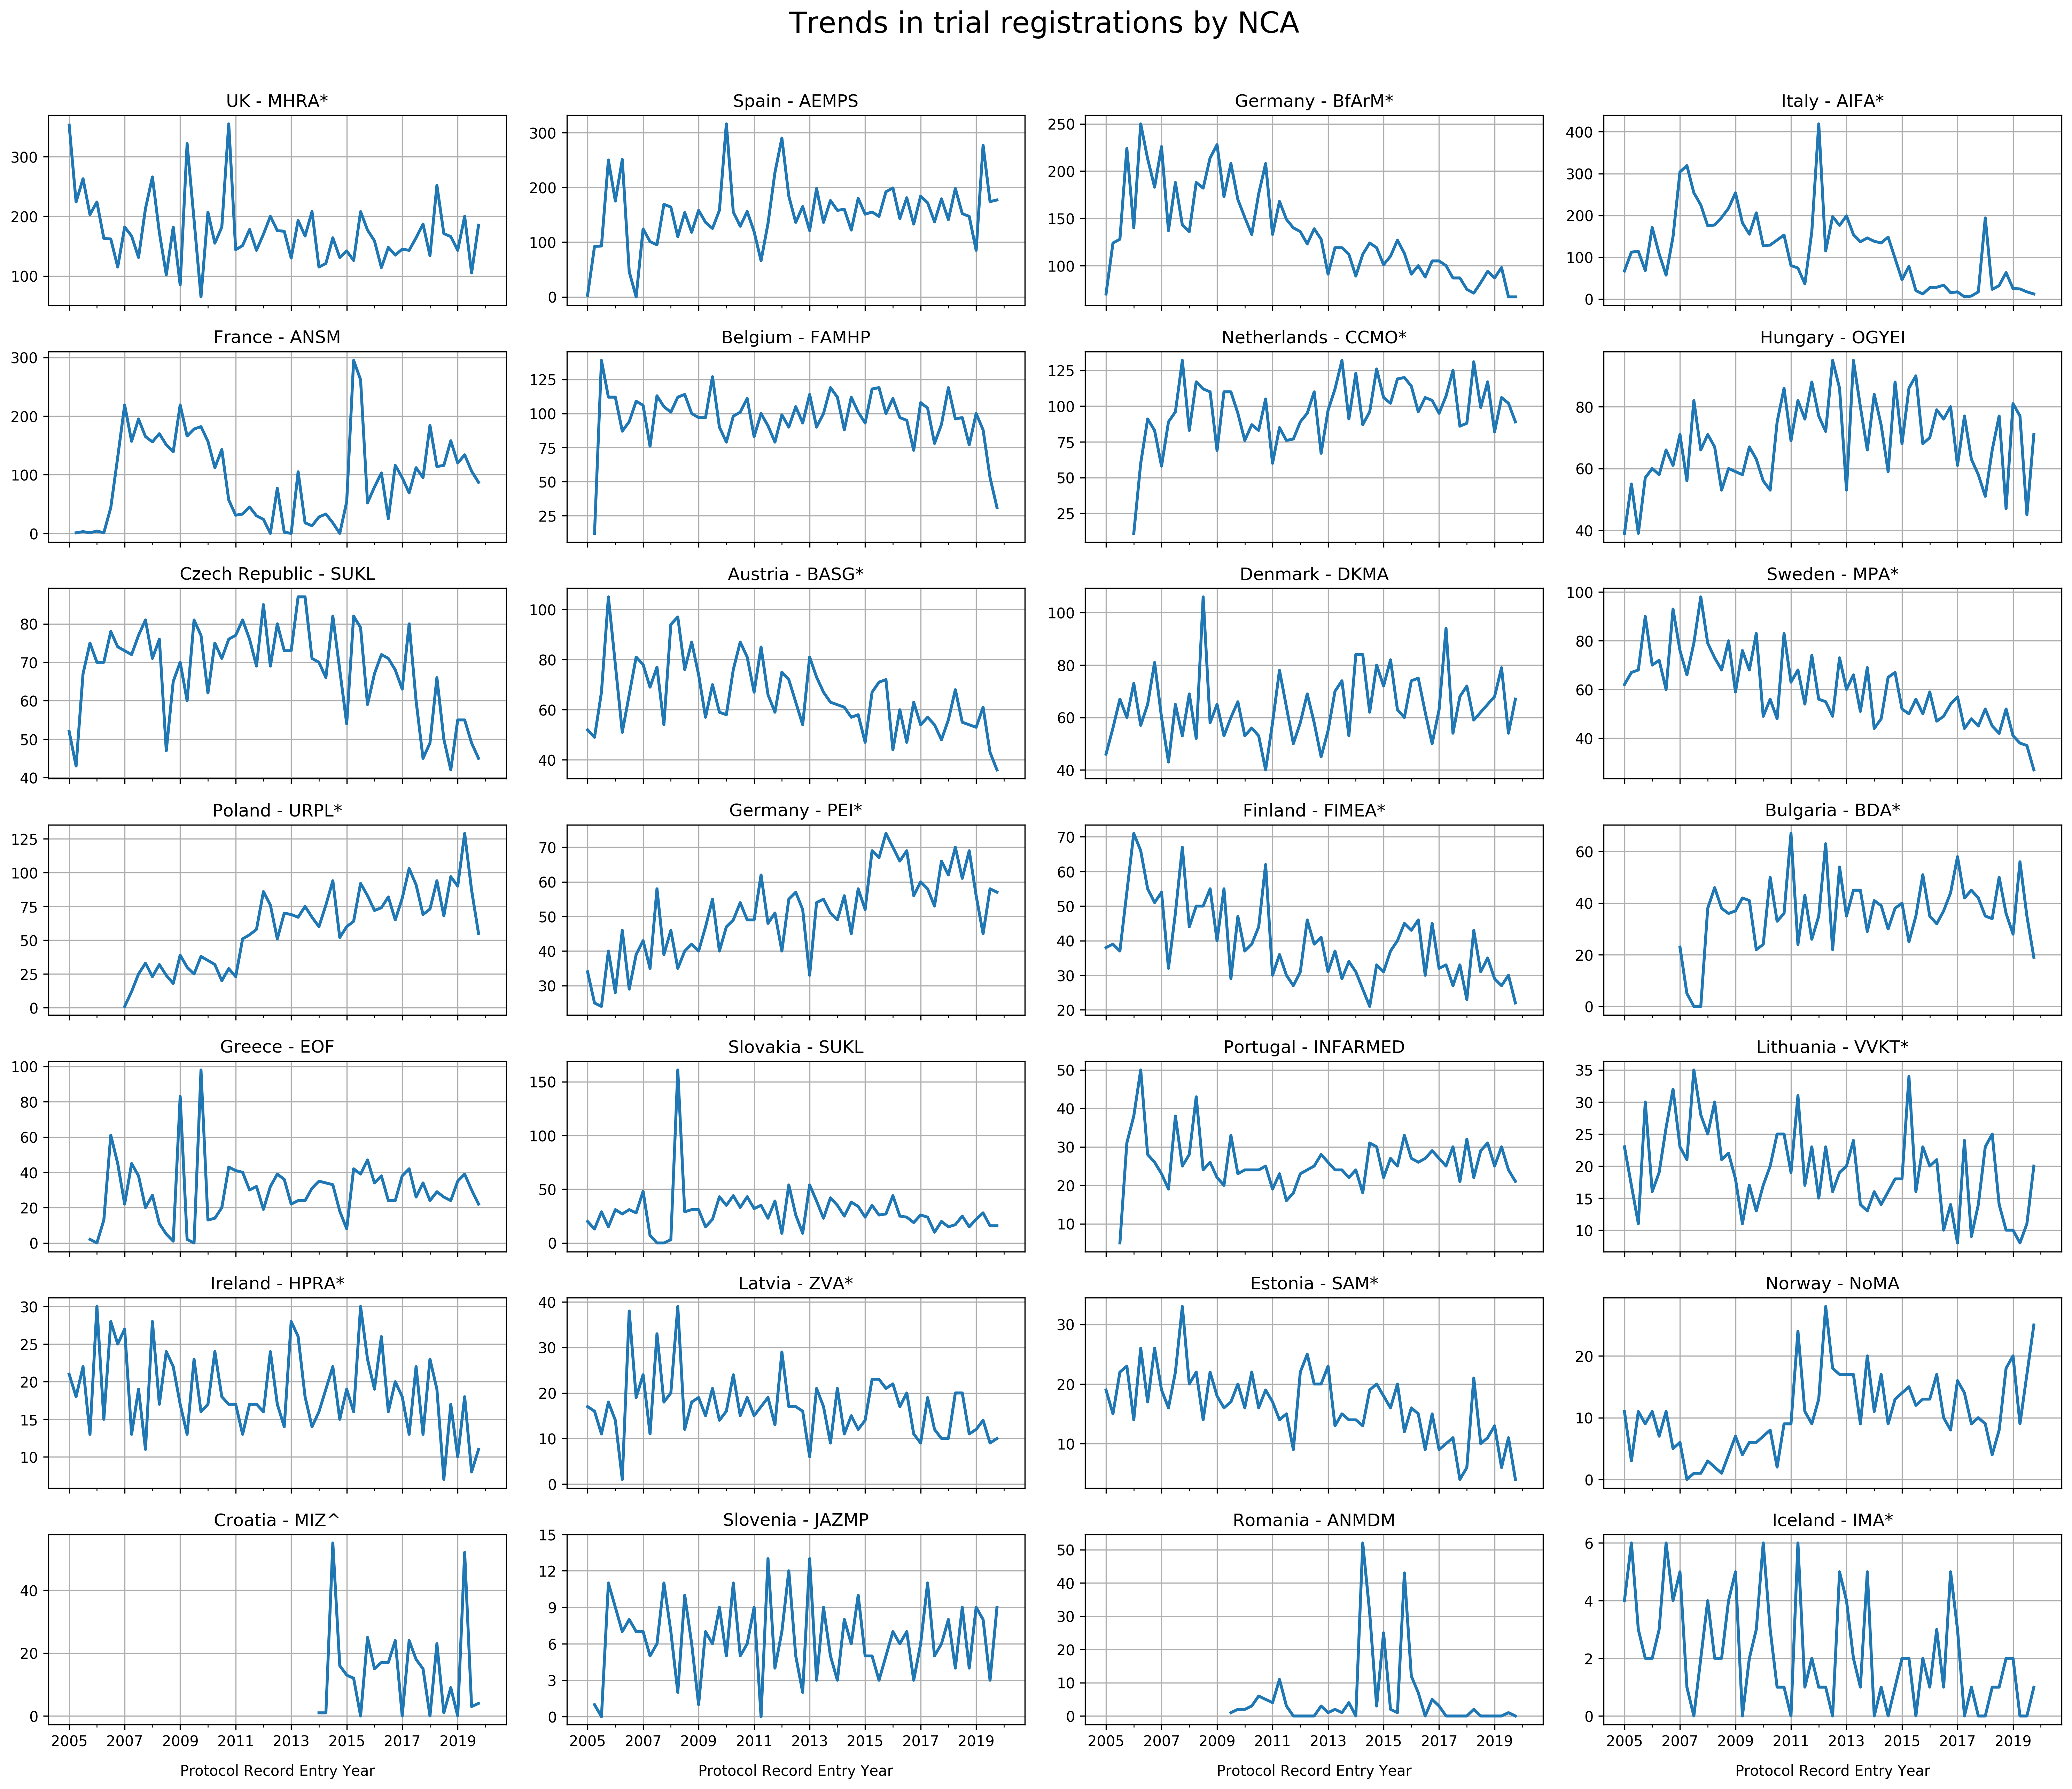

In [404]:
fig, axes = plt.subplots(figsize = (20, 16), nrows=7, ncols=4, dpi=300)
fig.suptitle("Trends in trial registrations by NCA", y=1.05, fontsize=20)
fig.tight_layout()

pd.set_option('mode.chained_assignment', None)
for x, y in enumerate(fig.axes):
    country = grouped.loc[ordered_countries_new[x]]
    first_reporting_quarter = country[country.eudract_number > 0].index.min()
    adjusted_data = zero_out_dict(country.to_dict()['eudract_number'], quarters) 
    data = pd.DataFrame({'eudract_number': adjusted_data})
    x_ticks = data.index
    
    #Get rid of leading zeros
    data['eudract_number'] = np.where(data.index < first_reporting_quarter, np.nan, data.eudract_number)
    
    consolidated = data[(data.index.year > 2004) & (data.index.year < 2020) & data.eudract_number.notnull()]
    
    leading_zero_check = True
    i=0
    
    while leading_zero_check:
        if consolidated.eudract_number[i] == 0:
            consolidated.at[consolidated.index[i], 'eudract_number'] = np.nan
            i+=1
        else:
            leading_zero_check = False
    
    consolidated = consolidated[consolidated.eudract_number.notnull()]
    
    if ordered_countries_new[x] != 'Croatia - MIZ':
        p = pv_df.loc[ordered_countries_new[x]][0]
        if p < .05:
            title = ordered_countries_new[x] + '*'
        else:
            title = ordered_countries_new[x]
    else:
        title = 'Croatia - MIZ' + '^'
    
    consolidated.plot(ax=y, lw=2, sharex='col',legend=False, title=title)
    
    #int_ordinal = np.arange(0,len(consolidated.index))
    
    #z = np.polyfit(int_ordinal, consolidated.eudract_number, 1)
    #p = np.poly1d(z)
    
    #consolidated['trend'] = p(int_ordinal)
    
    #consolidated.trend.plot(ax=y)
    
    
    if ordered_countries_original[x] == 'Slovenia - JAZMP':
        y.set_yticks(range(0,16,3))
    
    y.set_axisbelow(True)
    y.grid(zorder=0)
    y.set_xlabel('Protocol Record Entry Year', labelpad=10)
    y.set_xlim(x_ticks[0], x_ticks[-1])
    
pd.set_option('mode.chained_assignment', 'warn')
plt.show()

### Here we can compare NCA approval date to first entered date and see that the trends don't appreciably change.

In [761]:
grouped_year = reg_df[['eudract_number']].groupby([reg_df.nca, reg_df.entered_year]).count()
grouped_year_2 = reg_df[['eudract_number']].groupby([reg_df.nca, reg_df.approved_year]).count()

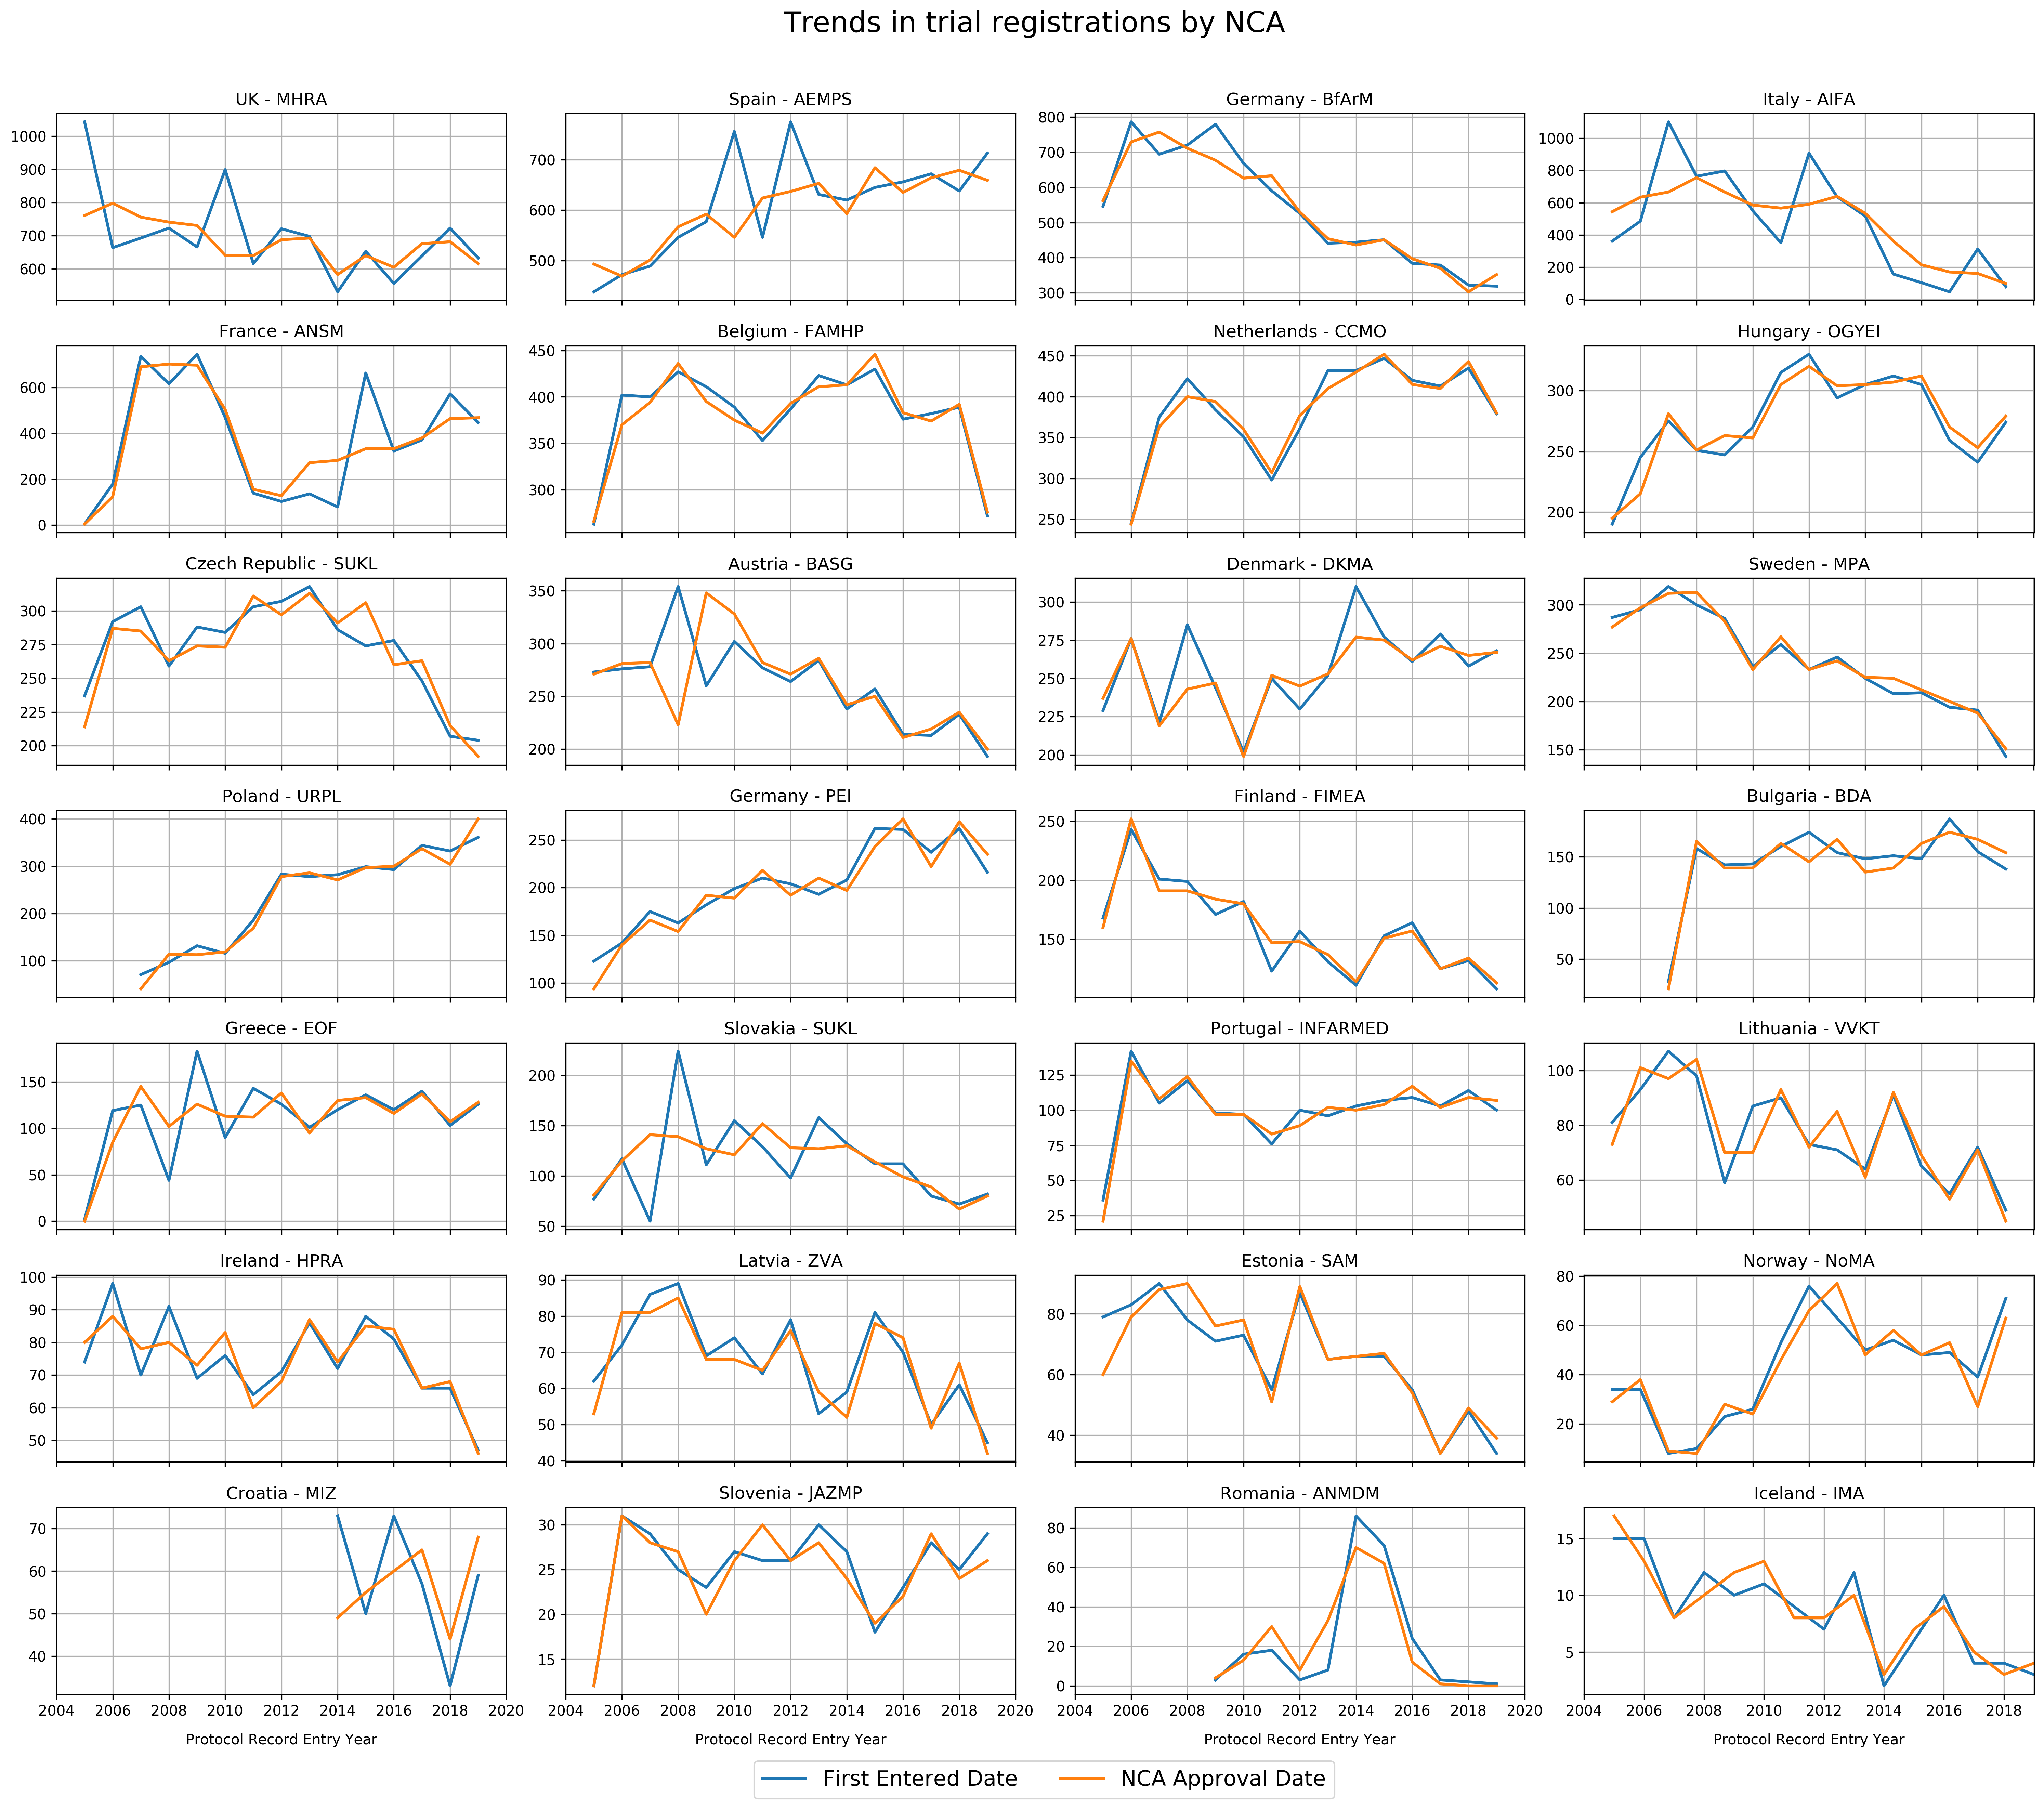

In [772]:
fig, axes = plt.subplots(figsize = (20, 16), nrows=7, ncols=4, dpi=300)
fig.suptitle("Trends in trial registrations by NCA", y=1.05, fontsize=20)
fig.tight_layout()

pd.set_option('mode.chained_assignment', None)
for x, y in enumerate(fig.axes):
    country = grouped_year.loc[ordered_countries_new[x]]
    country_2 = grouped_year_2.loc[ordered_countries_new[x]]
    first_reporting_quarter = country[country.eudract_number > 0].index.min()
    
    adjusted_data = zero_out_dict(country.to_dict()['eudract_number'], range(2004, 2020))
    adjusted_data_2 = zero_out_dict(country_2.to_dict()['eudract_number'], range(2004, 2020))
    
    data = pd.DataFrame({'eudract_number': adjusted_data})
    data_2 = pd.DataFrame({'eudract_number': adjusted_data_2})
    x_ticks = data.index
    
    #Get rid of leading zeros
    data['eudract_number'] = np.where(data.index < first_reporting_quarter, np.nan, data.eudract_number)
    data_2['eudract_number'] = np.where(data_2.index < first_reporting_quarter, np.nan, data_2.eudract_number)
    
    consolidated = data[(data.index > 2004) & (data.index < 2020) & data.eudract_number.notnull()]
    consolidated_2 = data_2[(data_2.index > 2004) & (data_2.index < 2020) & data_2.eudract_number.notnull()]
    
    leading_zero_check = True
    i=0
    
    while leading_zero_check:
        if consolidated.eudract_number.values[i] == 0:
            consolidated.at[consolidated.index[i], 'eudract_number'] = np.nan
            i+=1
        else:
            leading_zero_check = False
    
    while leading_zero_check:
        if consolidated_2.eudract_number.values[i] == 0:
            consolidated_2.at[consolidated_2.index[i], 'eudract_number'] = np.nan
            i+=1
        else:
            leading_zero_check = False
    
    consolidated = consolidated[consolidated.eudract_number.notnull()]
    consolidated_2 = consolidated_2[consolidated_2.eudract_number.notnull()]
    
    consolidated.plot(ax=y, lw=2, sharex='col',legend=False, title=ordered_countries_new[x])
    consolidated_2.plot(ax=y, lw=2, sharex='col',legend=False)
    
    y.set_axisbelow(True)
    y.grid(zorder=0)
    y.set_xlabel('Protocol Record Entry Year', labelpad=10)
    y.set_xlim(x_ticks[0], x_ticks[-1])
    
pd.set_option('mode.chained_assignment', 'warn')
plt.legend(['First Entered Date', 'NCA Approval Date'], 
           loc='upper center', ncol=5, bbox_to_anchor = (-1.2, -.3), fontsize=15)
plt.show()

# Trial Status By Country Over Time

In [425]:
status_df = analysis_df[['eudract_number', 'nca', 'entered_year', 'trial_status']].reset_index(drop=True)
status_df['trial_status'] = status_df.trial_status.fillna('Missing')

In [427]:
status_group = status_df.groupby(['nca', 'entered_year', 'trial_status'], as_index=False).count()

In [428]:
ordered_countries = list(status_group[['nca', 'eudract_number']].groupby('nca').sum().sort_values(by='eudract_number', ascending=False).index)

In [429]:
#Removing these for low number of trials
ordered_countries.remove('Malta - ADM')
ordered_countries.remove('Luxembourg - Ministry of Health')
ordered_countries.remove('Cyprus - MoH-Ph.S')

In [434]:
country_status = {}

for c in status_group.nca.unique():
    country_dict = {}
    country = status_group[status_group.nca == c]
    
    completed = country[country.trial_status.isin(['Completed', 'Prematurely Ended'])][['entered_year', 'eudract_number']].groupby('entered_year').sum()
    comp_dict = completed.to_dict()['eudract_number']
    country_dict['completed'] = zero_out_dict(comp_dict, range(2004,2021))
    
    ongoing = country[country.trial_status.isin(['Ongoing', 'Restarted'])][['entered_year', 'eudract_number']].groupby('entered_year').sum()
    ong_dict = ongoing.to_dict()['eudract_number']
    country_dict['ongoing'] = zero_out_dict(ong_dict, range(2004,2021))
    
    missing = country[country.trial_status == 'Missing']
    missing_dict = pd.Series(missing.eudract_number.values, index=missing.entered_year).to_dict()
    country_dict['missing'] = zero_out_dict(missing_dict, range(2004,2021))
    
    other = country[~country.trial_status.isin(['Completed', 'Ongoing', 'Restarted', 'Prematurely Ended', 'Missing'])][['entered_year', 'eudract_number']].groupby('entered_year').sum()
    other_dict = other.to_dict()['eudract_number']
    country_dict['other'] = zero_out_dict(other_dict, range(2004,2021))
    
    country_status[c] = country_dict

In [435]:
regrouped = pd.DataFrame.from_dict(country_status, orient='index').stack().to_frame()[0].apply(pd.Series).reindex(
    ['completed', 'ongoing', 'other', 'missing'], level=1)

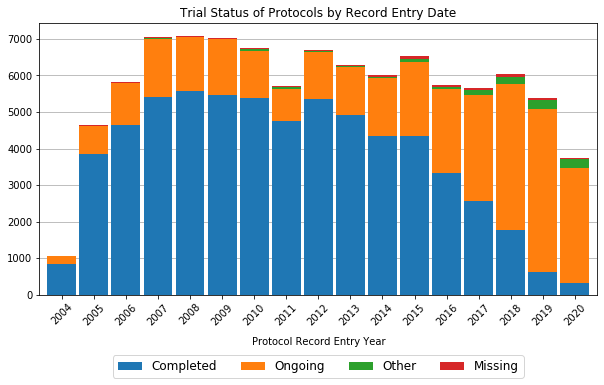

In [561]:
grouped_total = regrouped.droplevel(level=0).groupby(regrouped.droplevel(level=0).index).sum()

title='Trial Status of Protocols by Record Entry Date'


fig, ax = plt.subplots(figsize = (10,5))
grouped_total.reindex(['completed', 'ongoing', 'missing', 'other']).T.plot.bar(stacked=True, width=.9, ax=ax, 
                                                                               rot=45, title = title, legend=False)

ax.set_axisbelow(True)
ax.grid(axis='y', zorder=0)
ax.set_xlabel('Protocol Record Entry Year', labelpad=10)

plt.legend(['Completed', 'Ongoing', 'Other', 'Missing'], 
           loc='upper center', ncol=5, bbox_to_anchor = (0.5, -0.2), fontsize=12)
plt.show()

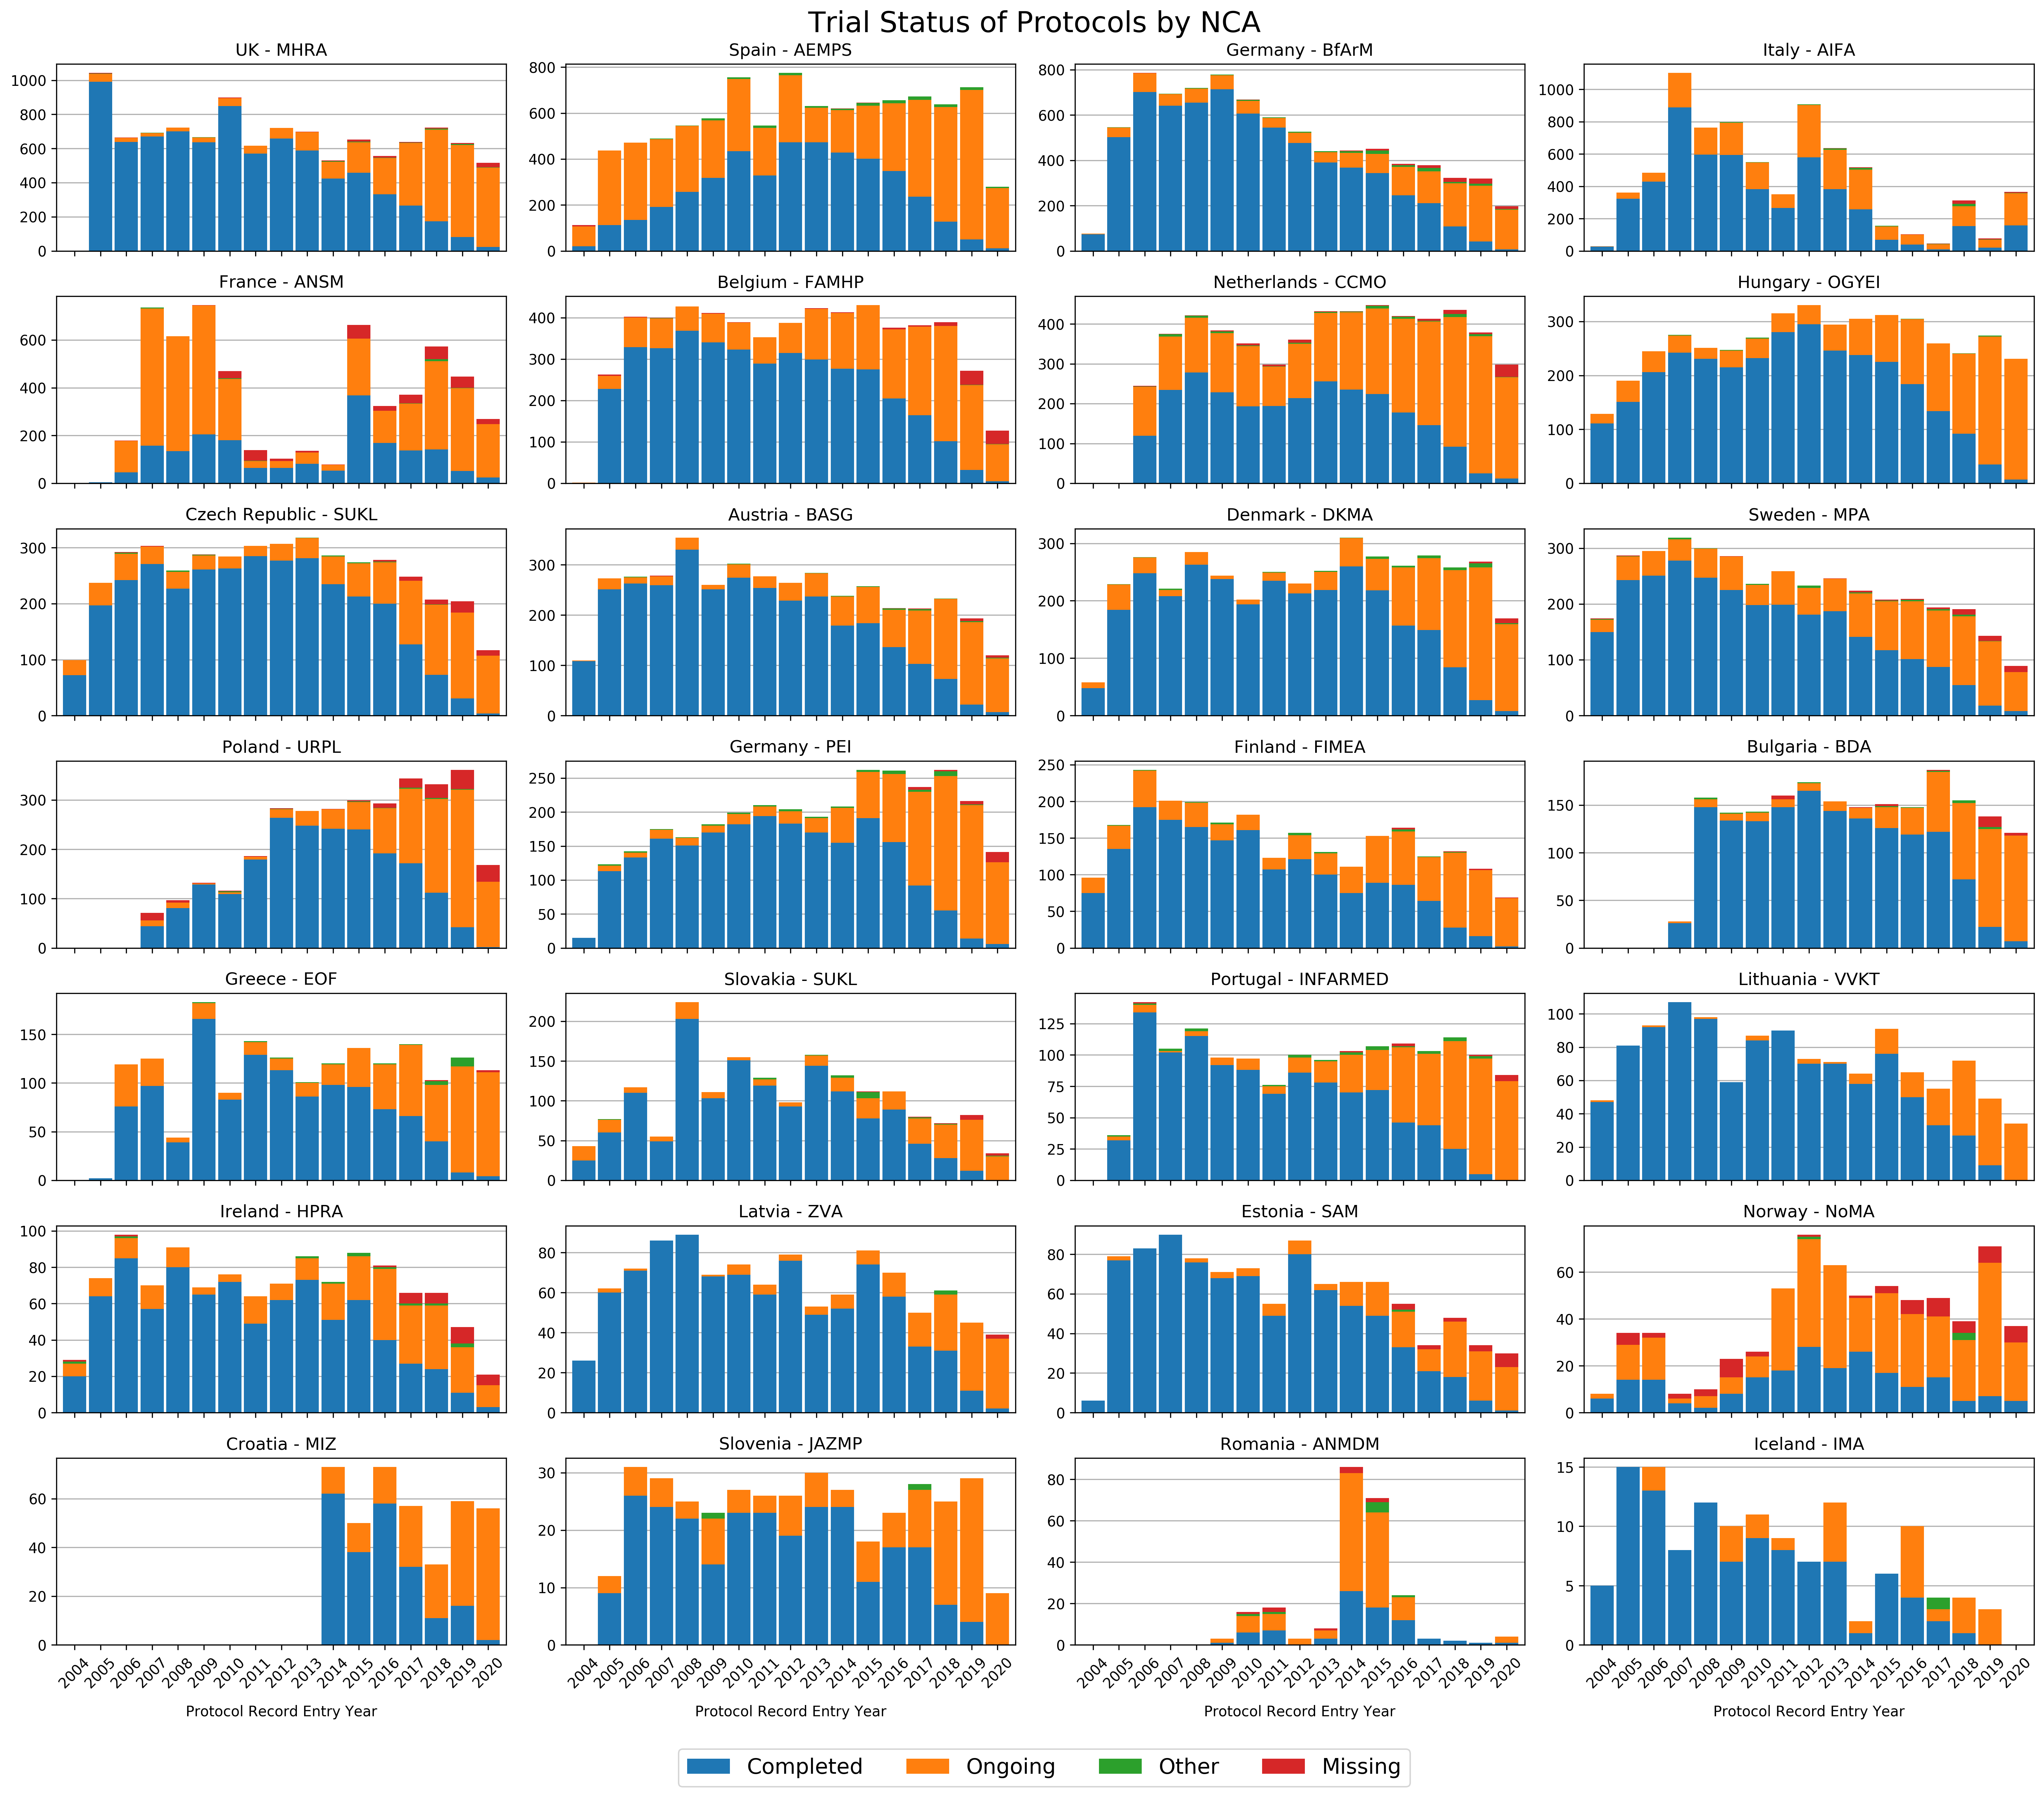

In [446]:
fig, axes = plt.subplots(figsize = (20, 16), nrows=7, ncols=4, dpi=300)
fig.suptitle("Trial Status of Protocols by NCA", y=1.02, fontsize=20)
fig.tight_layout()
for x, y in enumerate(fig.axes):
    regrouped.loc[[ordered_countries[x]]].droplevel(level=0).T.plot.bar(stacked=True, ax=y, width=.9, legend=False,
                                                                        sharex='col', rot=45,
                                                                        title=ordered_countries[x])
    
    y.set_axisbelow(True)
    y.grid(axis='y', zorder=0)
    y.set_xlabel('Protocol Record Entry Year', labelpad=10)


plt.legend(['Completed', 'Ongoing', 'Other', 'Missing'], 
           loc='upper center', ncol=5, bbox_to_anchor = (-1.2, -.5), fontsize=15)

plt.show()

# Missing Completion Dates

In [449]:
date_df = analysis_df[['eudract_number', 'nca', 'entered_year', 'trial_status', 'completion_date', 'trial_results']].reset_index(drop=True)
date_df['trial_status'] = date_df.trial_status.fillna('Missing')
date_df['has_completion_date'] = np.where(date_df.completion_date.isna(), 0, 1)

In [450]:
only_completed = date_df[date_df.trial_status.isin(['Completed', 'Prematurely Ended'])].reset_index(drop=True)

In [453]:
total_completed = only_completed[['nca', 
                                  'entered_year', 
                                  'has_completion_date']].groupby(['nca', 
                                                                   'entered_year']).count().rename({'has_completion_date': 'denominator'}, axis=1)

In [454]:
total_completed_date = only_completed[['nca', 'entered_year', 'has_completion_date']].groupby(['nca', 'entered_year']).sum().rename({'has_completion_date': 'numerator'}, axis=1)

In [455]:
merged_dates = total_completed.join(total_completed_date)
merged_dates['missing_dates'] = merged_dates.denominator - merged_dates.numerator

In [456]:
stacked_dates = merged_dates.drop('denominator', axis=1).stack().unstack(1)

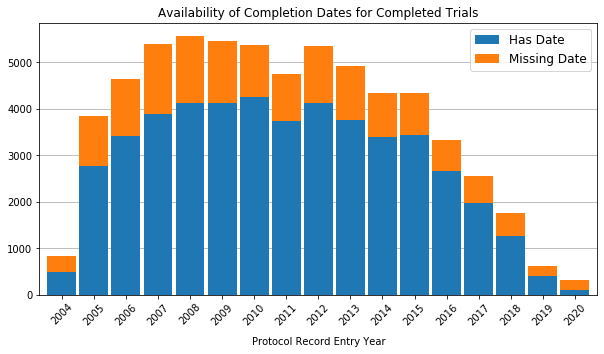

In [825]:
overall_dates = stacked_dates.droplevel(level=0).groupby(stacked_dates.droplevel(level=0).index).sum()

title='Availability of Completion Dates for Completed Trials'

fig, ax = plt.subplots(figsize = (10,5))
overall_dates.reindex(['numerator', 'missing_dates']).T.plot.bar(stacked=True, width=.9, ax=ax, legend=False, 
                                                                 rot=45, title=title)

ax.set_axisbelow(True)
ax.grid(axis='y', zorder=0)
ax.set_xlabel('Protocol Record Entry Year', labelpad=10)

plt.legend(['Has Date', 'Missing Date'], 
           loc='upper right', fontsize=12)
plt.show()

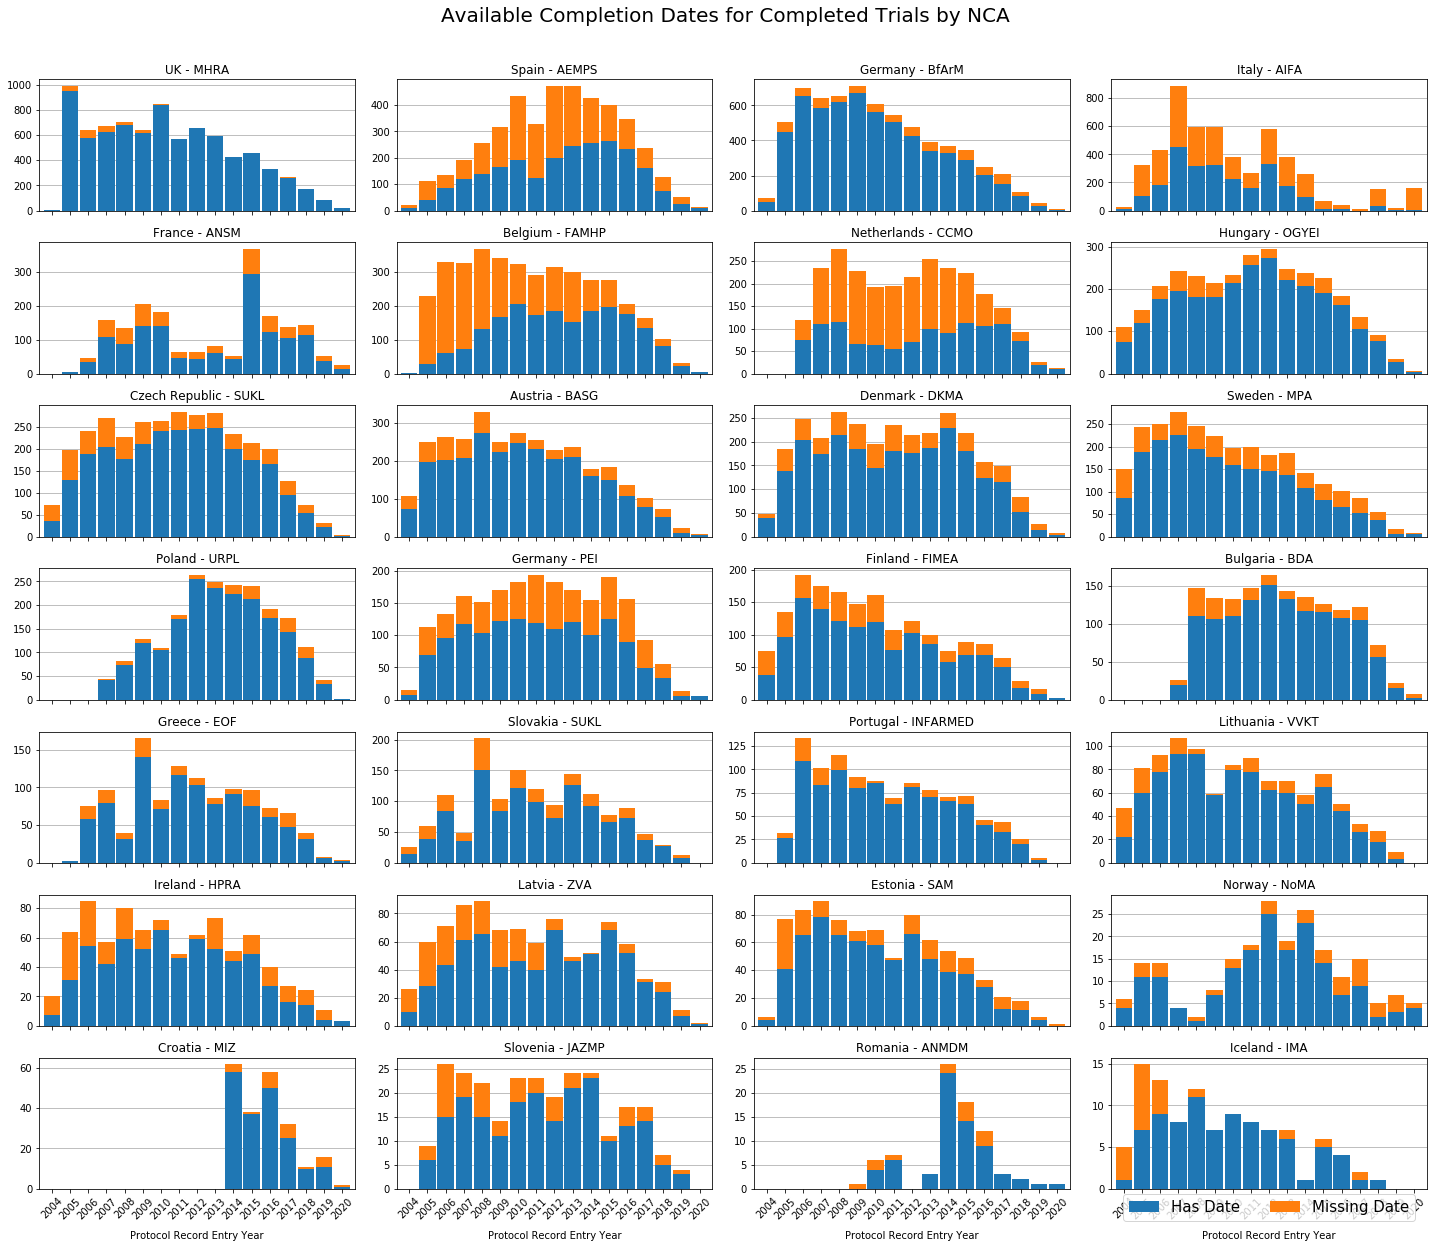

In [563]:
fig, axes = plt.subplots(figsize = (20, 16), nrows=7, ncols=4)
fig.suptitle("Available Completion Dates for Completed Trials by NCA", y=1.05, fontsize=20)
fig.tight_layout()

for x, y in enumerate(fig.axes):
    stacked_dates.loc[[ordered_countries[x]]].droplevel(level=0).T.plot.bar(stacked=True, ax=y, width=.9, 
                                                                            legend=False, sharex='col', rot=45, 
                                                                            title=ordered_countries[x])
    y.set_axisbelow(True)
    y.grid(axis='y', zorder=0)
    y.set_xlabel('Protocol Record Entry Year', labelpad=10)
    
plt.legend(['Has Date', 'Missing Date'], 
           loc='upper center', ncol=5, bbox_to_anchor = (0.5, .02), fontsize=15)

plt.show()

# Checking registered countries

In [571]:
results_info_filt = results_info[results_info.recruitment_countries.notnull()].reset_index(drop=True)

In [572]:
protocols = results_info_filt.trial_countries.to_list()
results_countries = results_info_filt.recruitment_countries.to_list()
start_date = results_info_filt.trial_start_date.to_list()
trial_ids = results_info_filt.trial_id.to_list()

zipped_cats = zip(trial_ids, protocols, results_countries, start_date)

In [573]:
results_list = compare_enrollment_registration(zipped_cats)

missing_protocols = pd.DataFrame(results_list)

In [574]:
acct = missing_protocols.accounted.to_list()
unacct = missing_protocols.unaccounted.to_list()

In [575]:
accounted_count = {}
unaccounted_count = {}
for ac, un in zip(acct, unacct):
    if ac:
        for a in ac:
            accounted_count[a] = accounted_count.get(a, 0) + 1
    if un:
        for u in un:
            unaccounted_count[u] = unaccounted_count.get(u, 0) + 1

In [576]:
accounted_series = pd.Series(accounted_count)
unaccounted_series = pd.Series(unaccounted_count)

In [577]:
reg_check_no_buffer = accounted_series.to_frame().join(unaccounted_series.to_frame(), how='outer', rsuffix='unac').rename({'0': 'accounted', '0unac': 'unaccounted'}, axis=1).fillna(0)

In [578]:
reg_check_no_buffer['total'] = reg_check_no_buffer['accounted'] + reg_check_no_buffer['unaccounted']

reg_check_no_buffer['acct_prct'] = round((reg_check_no_buffer['accounted'] / reg_check_no_buffer['total']) * 100, 2)

reg_check_no_buffer['unacct_prct'] = round((reg_check_no_buffer['unaccounted'] / reg_check_no_buffer['total']) * 100, 2)

In [579]:
reg_check_no_buffer

accounted  unaccounted   total  acct_prct  unacct_prct
Austria            1012.0         11.0  1023.0      98.92         1.08
Belgium            1718.0         46.0  1764.0      97.39         2.61
Bulgaria            797.0         67.0   864.0      92.25         7.75
Croatia             101.0          0.0   101.0     100.00         0.00
Cyprus                0.0          6.0     6.0       0.00       100.00
Czech Republic     1509.0         22.0  1531.0      98.56         1.44
Denmark             923.0         17.0   940.0      98.19         1.81
Estonia             354.0         25.0   379.0      93.40         6.60
Finland             587.0          7.0   594.0      98.82         1.18
France             1145.0       1207.0  2352.0      48.68        51.32
Germany            3101.0        226.0  3327.0      93.21         6.79
Greece              557.0         14.0   571.0      97.55         2.45
Hungary            1495.0         35.0  1530.0      97.71         2.29
Iceland              29.0          1.0    30.0      96.67         3.33
Ireland             293.0         20.0   313.0      93.61         6.39
Italy              1936.0        327.0  2263.0      85.55        14.45
Latvia              379.0          5.0   384.0      98.70         1.30
Lithuania           387.0          8.0   395.0      97.97         2.03
Luxembourg            1.0          2.0     3.0      33.33        66.67
Malta                 5.0          2.0     7.0      71.43        28.57
Netherlands        1179.0         67.0  1246.0      94.62         5.38
Norway              171.0        210.0   381.0      44.88        55.12
Poland             1291.0        831.0  2122.0      60.84        39.16
Portugal            453.0          7.0   460.0      98.48         1.52
Romania             148.0        726.0   874.0      16.93        83.07
Slovakia            601.0         16.0   617.0      97.41         2.59
Slovenia            115.0          5.0   120.0      95.83         4.17
Spain              2542.0         96.0  2638.0      96.36         3.64
Sweden              927.0         33.0   960.0      96.56         3.44
United Kingdom     3176.0        147.0  3323.0      95.58         4.42

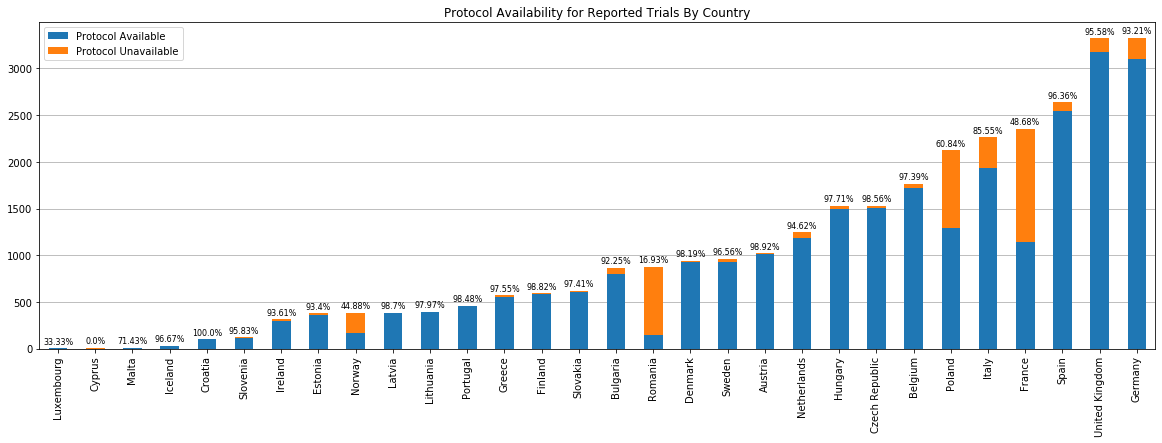

In [822]:
fig, ax = plt.subplots(figsize = (20,6))

title = 'Protocol Availability for Reported Trials By Country'

sorted_countries = reg_check_no_buffer.sort_values(by='total')
sorted_countries[['accounted', 'unaccounted']].plot.bar(stacked=True, ax=ax, title=title,
                                                        legend=False, width=.5)

ax.set_axisbelow(True)
ax.grid(axis='y', zorder=0)

rects = ax.patches[0:30]

for rect, label, y_off in zip(rects, sorted_countries.acct_prct.values, sorted_countries.total.values):
    ax.text(rect.get_x() + rect.get_width() / 2, y_off + 25, str(label) + '%', 
            ha='center', va='bottom', fontsize=8)

ax.legend(['Protocol Available', 'Protocol Unavailable'], 
           loc='upper left', fontsize=10)
    
plt.show()

In [824]:
22/30

0.7333333333333333

In [581]:
missing_protocols['total_missing'] = missing_protocols.unaccounted.apply(len)

In [582]:
missing_protocols[missing_protocols.total_missing > 1]

trial_id                                          protocols  \
28    2005-006083-57  ['BE', 'GB', 'CZ', 'DE', 'AT', 'HU', 'FI', 'SE...   
40    2009-011360-10  ['ES', 'PT', 'GB', 'NL', 'FI', 'LV', 'HU', 'CZ...   
41    2007-005668-28               ['GB', 'NL', 'PT', 'DE', 'CZ', 'FR']   
54    2010-020798-17                                             ['DE']   
66    2010-020859-30  ['BE', 'ES', 'DE', 'CZ', 'GB', 'HU', 'BG', 'LT...   
...              ...                                                ...   
8413  2018-001970-66                                             ['CZ']   
8416  2016-004217-26         ['DE', 'HU', 'SE', 'ES', 'CZ', 'FR', 'IT']   
8422  2015-003331-36                                       ['AT', 'NO']   
8428  2016-003503-64  ['EE', 'AT', 'DK', 'FI', 'IE', 'GB', 'SE', 'DE...   
8431  2016-004024-29   ['SK', 'DE', 'CZ', 'GB', 'GR', 'FR', 'ES', 'HR']   

                                  recruitment_countries date_exclusions  \
28    [Poland, Israel, Peru, Russian Federation, Sou...        [Poland]   
40    [Slovakia, Slovenia, South Africa, Spain, Swed...       [Croatia]   
41    [United Kingdom, United States, Argentina, Bra...              []   
54    [Germany, Poland, Romania, Russian Federation,...              []   
66    [South Africa, Spain, Taiwan, Ukraine, United ...              []   
...                                                 ...             ...   
8413                  [Poland, Czech Republic, Germany]              []   
8416  [Poland, Spain, Sweden, Czech Republic, France...              []   
8422                  [Spain, Austria, Germany, Norway]              []   
8428  [South Africa, Spain, Sweden, Switzerland, Tai...              []   
8431  [Argentina, Brazil, Canada, China, Czechia, Ge...              []   

                                        non_eu_excluded  \
28    [Israel, Peru, Russian Federation, South Afric...   
40    [South Africa, Switzerland, Taiwan, Thailand, ...   
41           [United States, Argentina, Brazil, Canada]   
54         [Russian Federation, Ukraine, United States]   
66    [South Africa, Taiwan, Ukraine, United States,...   
...                                                 ...   
8413                                                 []   
8416              [Russian Federation, Serbia, Ukraine]   
8422                                                 []   
8428  [South Africa, Switzerland, Taiwan, Turkey, Uk...   
8431  [Argentina, Brazil, Canada, China, Czechia, In...   

                                              accounted  \
28    [Austria, Belgium, Germany, Czech Republic, It...   
40    [Finland, Estonia, Ireland, Slovenia, Norway, ...   
41        [Czech Republic, United Kingdom, Netherlands]   
54                                            [Germany]   
66    [Estonia, Hungary, United Kingdom, Bulgaria, B...   
...                                                 ...   
8413                                   [Czech Republic]   
8416  [Hungary, France, Czech Republic, Germany, Spa...   
8422                                  [Austria, Norway]   
8428  [Estonia, Ireland, Norway, United Kingdom, Bel...   
8431  [United Kingdom, France, Germany, Croatia, Gre...   

                    unaccounted  total_missing  
28             [France, Norway]              2  
40            [Romania, Poland]              2  
41             [Norway, Poland]              2  
54            [Romania, Poland]              2  
66    [France, Romania, Poland]              3  
...                         ...            ...  
8413          [Germany, Poland]              2  
8416          [Romania, Poland]              2  
8422           [Germany, Spain]              2  
8428            [France, Italy]              2  
8431           [Romania, Italy]              2  

[966 rows x 8 columns]

In [583]:
min_start_date = analysis_df[['eudract_number', 'entered_year']].groupby('eudract_number', as_index=False).min()

by_year_df = missing_protocols.merge(min_start_date, how='left', left_on='trial_id', right_on='eudract_number').drop('eudract_number', axis=1)

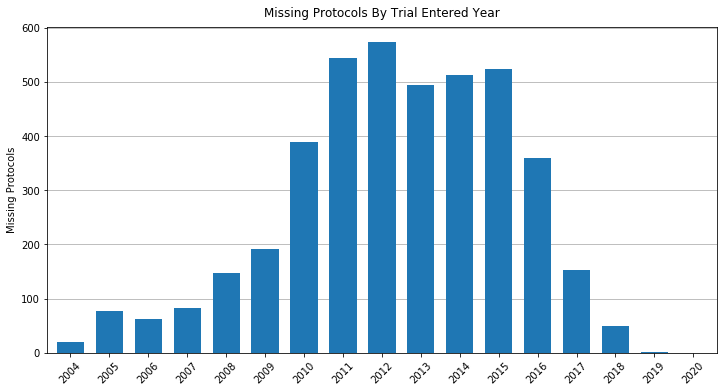

In [584]:
fig, ax = plt.subplots(figsize = (12,6))

to_graph = by_year_df[['entered_year', 'total_missing']].groupby('entered_year').sum()
to_graph.index = to_graph.index.astype(int)

to_graph.plot.bar(ax=ax, legend=False, width=.7, rot=45)

ax.set_axisbelow(True)
ax.grid(axis='y', zorder=0)
plt.title('Missing Protocols By Trial Entered Year', pad=10)
plt.ylabel('Missing Protocols')
    
plt.show()

**Using longer lags between the first available protocol for a country to see if it makes a difference. This can be adjusted to reproduce with offsets of 6 and 12 months in the `compare_enrollment_registration` function**

In [596]:
protocols = results_info_filt.trial_countries.to_list()
results_countries = results_info_filt.recruitment_countries.to_list()
start_date = results_info_filt.trial_start_date.to_list()
trial_ids = results_info_filt.trial_id.to_list()

zipped_cats = zip(trial_ids, protocols, results_countries, start_date)

results_sens = compare_enrollment_registration(zipped_cats, offset=6)

missing_sensitivity = pd.DataFrame(results_sens)

In [594]:
acct_sens = missing_sensitivity.accounted.to_list()
unacct_sens = missing_sensitivity.unaccounted.to_list()

In [595]:
accounted_count_sens = {}
unaccounted_count_sens = {}
for ac, un in zip(acct_sens, unacct_sens):
    if ac:
        for a in ac:
            accounted_count_sens[a] = accounted_count_sens.get(a, 0) + 1
    if un:
        for u in un:
            unaccounted_count_sens[u] = unaccounted_count_sens.get(u, 0) + 1

In [597]:
accounted_series_sens = pd.Series(accounted_count_sens)
unaccounted_series_sens = pd.Series(unaccounted_count_sens)

In [601]:
reg_check_buffer = accounted_series_sens.to_frame().join(unaccounted_series_sens.to_frame(), how='outer', rsuffix='unac').rename({'0': 'accounted', '0unac': 'unaccounted'}, axis=1).fillna(0)

In [602]:
reg_check_buffer['total'] = reg_check_buffer['accounted'] + reg_check_buffer['unaccounted']
reg_check_buffer['acct_prct'] = round((reg_check_buffer['accounted'] / reg_check_buffer['total']) * 100, 2)

In [603]:
reg_check_buffer

accounted  unaccounted   total  acct_prct
Austria            1004.0         10.0  1014.0      99.01
Belgium            1708.0         39.0  1747.0      97.77
Bulgaria            793.0         66.0   859.0      92.32
Croatia              88.0          0.0    88.0     100.00
Cyprus                0.0          6.0     6.0       0.00
Czech Republic     1500.0         21.0  1521.0      98.62
Denmark             917.0         16.0   933.0      98.29
Estonia             354.0         25.0   379.0      93.40
Finland             583.0          5.0   588.0      99.15
France             1142.0       1187.0  2329.0      49.03
Germany            3086.0        218.0  3304.0      93.40
Greece              553.0         11.0   564.0      98.05
Hungary            1491.0         35.0  1526.0      97.71
Iceland              27.0          1.0    28.0      96.43
Ireland             291.0         20.0   311.0      93.57
Italy              1923.0        327.0  2250.0      85.47
Latvia              379.0          5.0   384.0      98.70
Lithuania           386.0          8.0   394.0      97.97
Luxembourg            1.0          2.0     3.0      33.33
Malta                 5.0          2.0     7.0      71.43
Netherlands        1170.0         63.0  1233.0      94.89
Norway              171.0        207.0   378.0      45.24
Poland             1276.0        807.0  2083.0      61.26
Portugal            449.0          6.0   455.0      98.68
Romania             146.0        698.0   844.0      17.30
Slovakia            601.0         15.0   616.0      97.56
Slovenia            114.0          4.0   118.0      96.61
Spain              2536.0         94.0  2630.0      96.43
Sweden              921.0         32.0   953.0      96.64
United Kingdom     3159.0        144.0  3303.0      95.64

# Trend in Results Availability by registration year

In [606]:
reporting_by_country = analysis_df[['eudract_number', 'nca', 'entered_year', 
                                    'approved_year', 'trial_results']].reset_index(drop=True)

reporting_by_country['results_dummy'] = np.where(reporting_by_country.trial_results == 'View results', 1, 0)

In [607]:
eu_protocol_count = reporting_by_country.groupby('eudract_number').count()[['nca']].reset_index()

eu_protocol_count.columns = ['eudract_number', 'nca_count']

Creating data for trials with only a single CTA

In [609]:
solo_merge = reporting_by_country.merge(eu_protocol_count, how='left', on='eudract_number')

In [610]:
total = solo_merge[solo_merge.nca_count == 1][['nca', 'entered_year', 'results_dummy']].groupby(['nca', 'entered_year']).count().rename({'results_dummy': 'denominator'}, axis=1)

reported = solo_merge[solo_merge.nca_count == 1][['nca', 'entered_year', 'results_dummy']].groupby(['nca', 'entered_year']).sum().rename({'results_dummy': 'numerator'}, axis=1)

In [617]:
merged = total.join(reported)
merged['unreported'] = merged.denominator - merged.numerator

In [618]:
stacked = merged.drop('denominator', axis=1).stack().unstack(1)

Creating data for trials with multiple CTAs

In [ ]:
multi_set = solo_merge[solo_merge.nca_count > 1][['eudract_number', 'results_dummy', 'entered_year']].drop_duplicates()

In [ ]:
multi_group = multi_set.groupby('eudract_number', as_index=False).agg('min')[['entered_year', 'results_dummy']].groupby('entered_year').agg({'results_dummy':['count', 'sum']})['results_dummy']
multi_group['prct'] = round((multi_group['sum'] / multi_group['count']) * 100, 2)

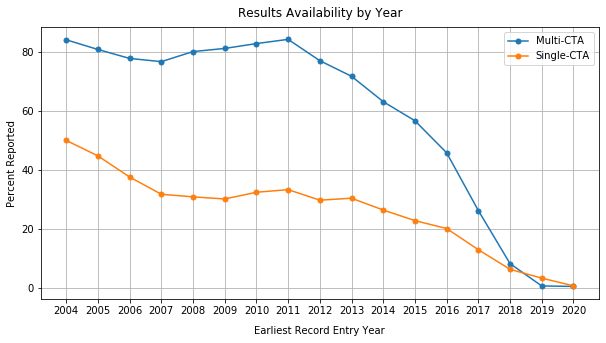

In [893]:
num = stacked.loc[pd.IndexSlice[:, 'numerator'], :].sum()
denom = (num + stacked.loc[pd.IndexSlice[:, 'unreported'], :].sum())

fig, ax = plt.subplots(figsize = (10,5))

plt.plot(range(2004,2021), multi_group.prct, marker='.', markersize=10)
plt.plot(range(2004,2021), ((num) / (denom)) * 100, marker='.', markersize=10)

ax.set_xticks(range(2004,2021))

ax.legend(['Multi-CTA', 'Single-CTA'], loc='upper right', fontsize=10)
ax.set_axisbelow(True)
ax.grid(zorder=0)

plt.ylabel('Percent Reported')
plt.xlabel('Earliest Record Entry Year', labelpad=10)

plt.title('Results Availability by Year', pad=10)
plt.show()

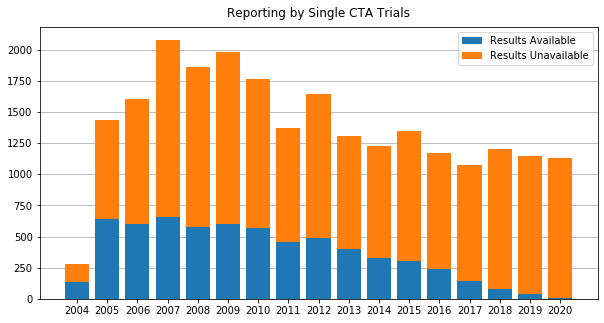

In [836]:
fig, ax = plt.subplots(figsize = (10,5))
plt.bar(range(2004,2021), stacked.loc[pd.IndexSlice[:, 'numerator'], :].sum())
plt.bar(range(2004,2021), stacked.loc[pd.IndexSlice[:, 'unreported'], :].sum(), bottom=stacked.loc[pd.IndexSlice[:, 'numerator'], :].sum())
ax.set_xticks(range(2004,2021))

ax.legend(['Results Available', 'Results Unavailable'], 
           loc='upper right', fontsize=10)
ax.set_axisbelow(True)
ax.grid(axis='y', zorder=0)

rects = ax.patches[0:30]

plt.title('Reporting by Single CTA Trials', pad=10)
plt.show()

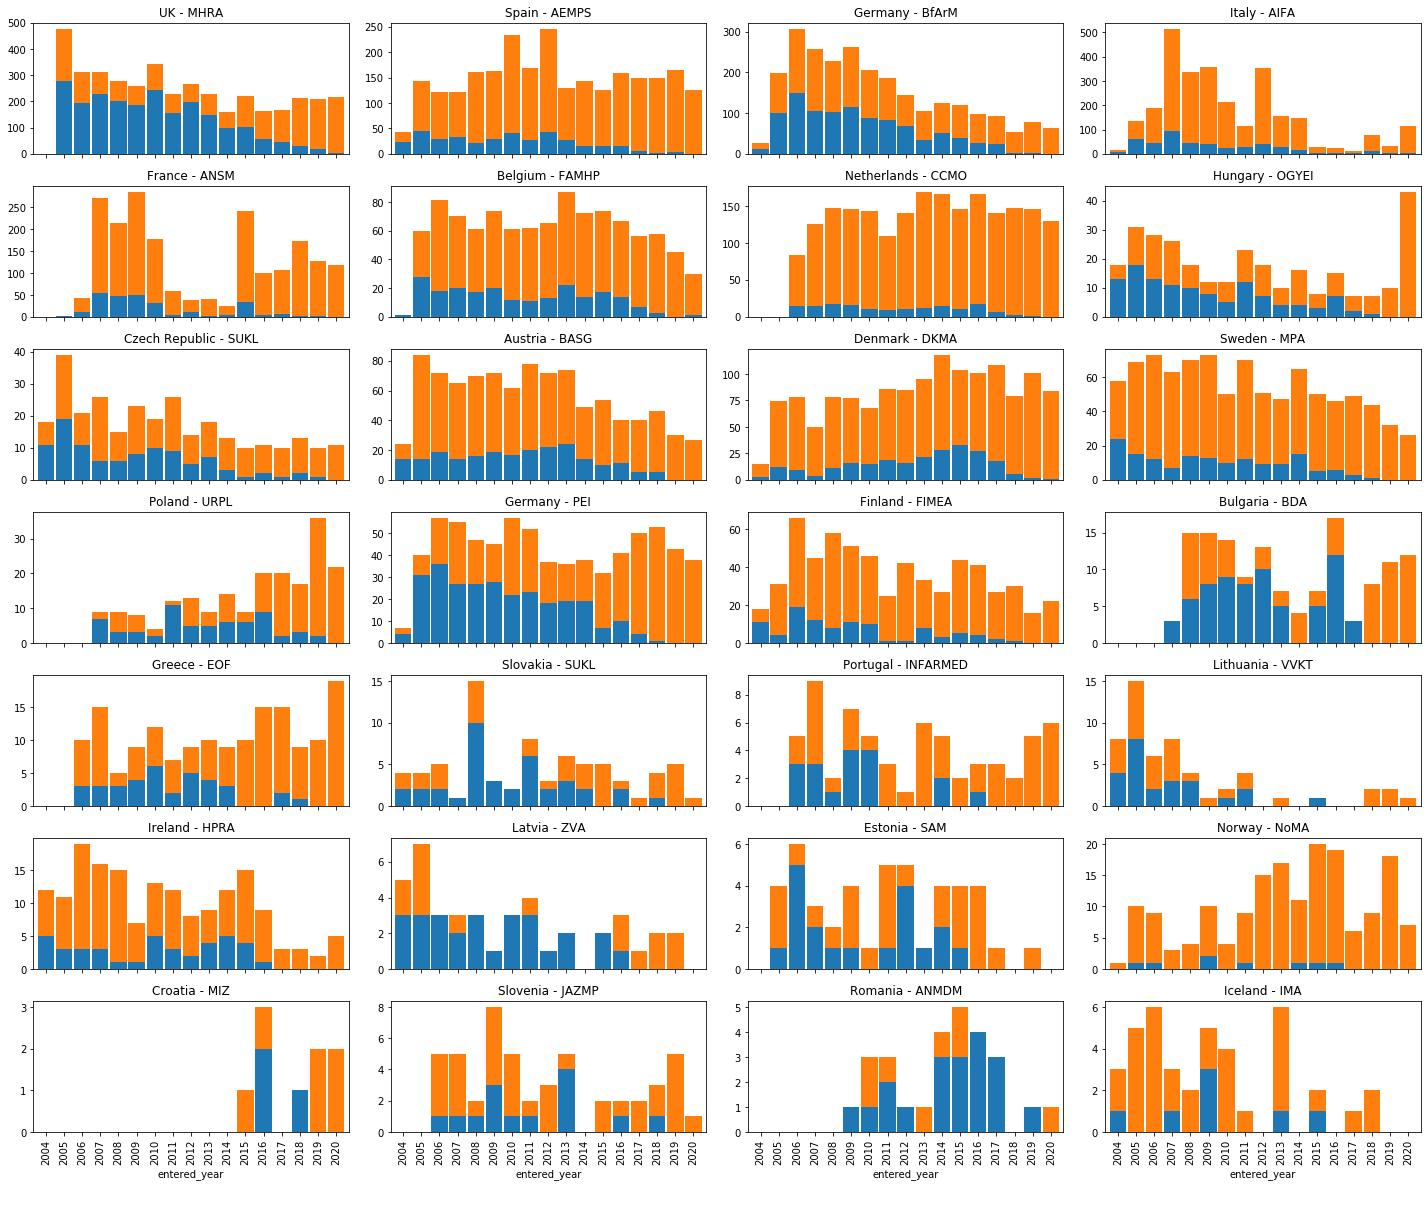

In [620]:
fig, axes = plt.subplots(figsize = (20, 16), nrows=7, ncols=4)
fig.tight_layout()
for x, y in enumerate(fig.axes):
    stacked.loc[[ordered_countries[x]]].droplevel(level=0).T.plot.bar(stacked=True, ax=y, width=.9, legend=False,
                                                                        sharex='col', title=ordered_countries[x])

fig.legend(['Reported', 'Unreported'], 
           loc='upper center', ncol=5, bbox_to_anchor = (0.5, -0.01), fontsize=15)
plt.show()

In [859]:
multi_set = solo_merge[solo_merge.nca_count > 1][['eudract_number', 'results_dummy', 'entered_year']].drop_duplicates()

In [877]:
multi_group = multi_set.groupby('eudract_number', as_index=False).agg('min')[['entered_year', 'results_dummy']].groupby('entered_year').agg({'results_dummy':['count', 'sum']})['results_dummy']

In [881]:
multi_group['prct'] = round((multi_group['sum'] / multi_group['count']) * 100, 2)

In [882]:
multi_group

count  sum   prct
entered_year                   
2004            371  312  84.10
2005            850  687  80.82
2006            887  690  77.79
2007           1008  773  76.69
2008            905  725  80.11
2009            908  737  81.17
2010            885  733  82.82
2011            857  722  84.25
2012            879  677  77.02
2013            863  619  71.73
2014            857  541  63.13
2015            886  502  56.66
2016            869  398  45.80
2017            858  225  26.22
2018            863   71   8.23
2019            749    5   0.67
2020            402    2   0.50

**We can compare this to trials that take place in multiple countries**

In [622]:
total_multi = solo_merge[solo_merge.nca_count > 1][['nca', 'entered_year', 'results_dummy']].groupby(['nca', 'entered_year']).count().rename({'results_dummy': 'denominator'}, axis=1)

In [623]:
reported_multi = solo_merge[solo_merge.nca_count > 1][['nca', 'entered_year', 'results_dummy']].groupby(['nca', 'entered_year']).sum().rename({'results_dummy': 'numerator'}, axis=1)

In [624]:
merged_multi = total_multi.join(reported_multi)
merged_multi['unreported'] = merged_multi.denominator - merged_multi.numerator

In [625]:
stacked_multi = merged_multi.drop('denominator', axis=1).stack().unstack(1)

In [851]:
stacked_multi

entered_year                 2004   2005   2006   2007   2008   2009   2010  \
nca                                                                           
Austria - BASG  numerator    76.0  156.0  169.0  179.0  242.0  165.0  191.0   
                unreported   10.0   33.0   35.0   34.0   42.0   23.0   49.0   
Belgium - FAMHP numerator     1.0  170.0  264.0  266.0  305.0  288.0  276.0   
                unreported    0.0   33.0   57.0   64.0   61.0   49.0   52.0   
Bulgaria - BDA  numerator     NaN    NaN    NaN   20.0  122.0  109.0  108.0   
...                           ...    ...    ...    ...    ...    ...    ...   
Spain - AEMPS   unreported    7.0   42.0   46.0   54.0   47.0   56.0   69.0   
Sweden - MPA    numerator   104.0  184.0  193.0  218.0  196.0  184.0  166.0   
                unreported   12.0   34.0   29.0   38.0   34.0   29.0   20.0   
UK - MHRA       numerator     1.0  479.0  282.0  305.0  372.0  344.0  479.0   
                unreported    0.0   87.0   71.0   75.0   73.0   64.0   77.0   

entered_year                 2011   2012   2013   2014   2015   2016   2017  \
nca                                                                           
Austria - BASG  numerator   170.0  150.0  161.0  113.0  108.0   60.0   39.0   
                unreported   29.0   42.0   49.0   76.0   95.0  114.0  134.0   
Belgium - FAMHP numerator   253.0  262.0  250.0  218.0  193.0  140.0   83.0   
                unreported   38.0   60.0   86.0  123.0  163.0  169.0  243.0   
Bulgaria - BDA  numerator   139.0  149.0  123.0  112.0  106.0   74.0   82.0   
...                           ...    ...    ...    ...    ...    ...    ...   
Spain - AEMPS   unreported   55.0   90.0  115.0  168.0  219.0  268.0  385.0   
Sweden - MPA    numerator   161.0  149.0  147.0   98.0   91.0   65.0   38.0   
                unreported   28.0   33.0   52.0   61.0   67.0   98.0  107.0   
UK - MHRA       numerator   336.0  372.0  361.0  251.0  249.0  175.0  119.0   
                unreported   50.0   82.0  110.0  119.0  182.0  218.0  354.0   

entered_year                 2018   2019   2020  
nca                                              
Austria - BASG  numerator    14.0    0.0    0.0  
                unreported  173.0  163.0   93.0  
Belgium - FAMHP numerator    28.0    2.0    0.0  
                unreported  303.0  225.0   97.0  
Bulgaria - BDA  numerator    20.0    2.0    0.0  
...                           ...    ...    ...  
Spain - AEMPS   unreported  445.0  546.0  153.0  
Sweden - MPA    numerator    16.0    1.0    1.0  
                unreported  131.0  110.0   62.0  
UK - MHRA       numerator    39.0    9.0    3.0  
                unreported  472.0  413.0  295.0  

[62 rows x 17 columns]

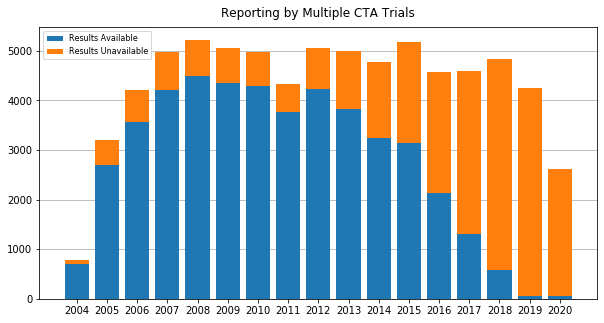

In [841]:
fig, ax = plt.subplots(figsize = (10,5))
plt.bar(range(2004,2021), stacked_multi.loc[pd.IndexSlice[:, 'numerator'], :].sum())
plt.bar(range(2004,2021), stacked_multi.loc[pd.IndexSlice[:, 'unreported'], :].sum(), bottom=stacked_multi.loc[pd.IndexSlice[:, 'numerator'], :].sum())
ax.set_xticks(range(2004,2021))
ax.legend(['Results Available', 'Results Unavailable'], 
           loc='upper left', fontsize=8)
plt.title('Reporting by Multiple CTA Trials', pad=10)
ax.set_axisbelow(True)
ax.grid(axis='y', zorder=0)
plt.show()

In [627]:
stacked_multi.loc[pd.IndexSlice[:, 'unreported'], :].sum()

entered_year
2004      94.0
2005     494.0
2006     638.0
2007     768.0
2008     736.0
2009     697.0
2010     700.0
2011     557.0
2012     837.0
2013    1159.0
2014    1531.0
2015    2031.0
2016    2441.0
2017    3275.0
2018    4251.0
2019    4183.0
2020    2552.0
dtype: float64

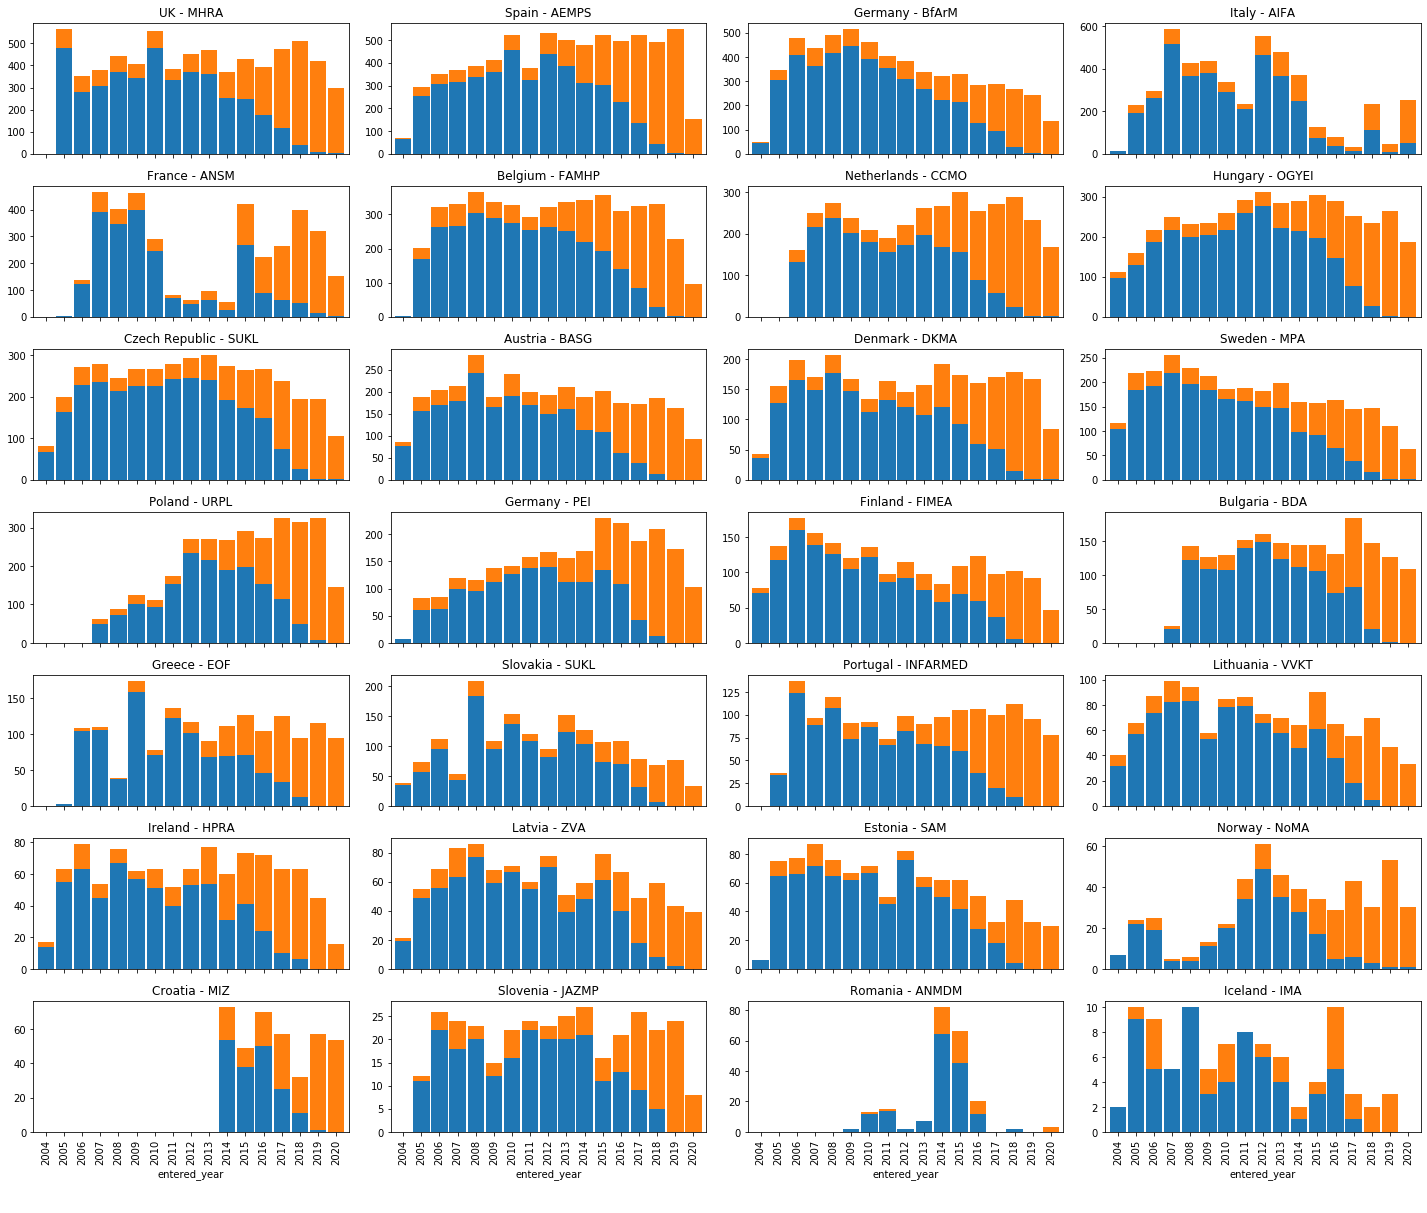

In [628]:
fig, axes = plt.subplots(figsize = (20, 16), nrows=7, ncols=4)
fig.tight_layout()
for x, y in enumerate(fig.axes):
    stacked_multi.loc[[ordered_countries[x]]].droplevel(level=0).T.plot.bar(stacked=True, ax=y, width=.9, legend=False,
                                                                        sharex='col', title=ordered_countries[x])

fig.legend(['Reported', 'Unreported'], 
           loc='upper center', ncol=5, bbox_to_anchor = (0.5, -0.01), fontsize=15)
plt.show()